# Estratérgias de Treinamentos

* Binário: 

    - 
    ( SM + Background ) = 0
    
      ANOMALOS{i} = 1
      
    - 
    ( Background ) = 0
    
      ( ANOMALO_{i} + SM ) = 1 
      

Fazer corte no xi dos protons de 0.02 e 0.03

* Multiclasse:


    - Background = 0
    - SM = 1
    - ANOMALO_{i} = 2    
    
    - Background = 0
    - SM = 1
    - ANOMALO's = 2 ( todos os anômalos juntos )
    
    - Background -( W+Jatos ou ttbar ) = 0
    - SM = 1
    - ANOMALO_{i} = 2    
    - W+jatos = 3 ( ou ttbar = 3 )

* Proximos passos
Olhar na literatura como colocar limites nas observações novas( testes estatísticos, hipótese nula, "brazillian plots" )

In [4]:
from __future__ import print_function, division

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import lightgbm as lgb
import sys
from matplotlib.colors import ListedColormap
import seaborn as sns
import mplhep as hep
from sklearn.metrics import make_scorer,fbeta_score,precision_score,recall_score,accuracy_score,log_loss,roc_auc_score,classification_report,f1_score,confusion_matrix,roc_curve,precision_recall_curve,average_precision_score,plot_precision_recall_curve,plot_roc_curve

In [2]:
plt.style.use(hep.style.ROOT)

# Função que abre os aquivos .h5

In [3]:
# Signal
def open_file_signal( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset )
        array_cut = ( array[:,13] > 0 ) & ( array[:,14] > 0 )  # Corte no xi1 e no xi2
        DataSet = array[array_cut]   
        DataSet = np.delete(DataSet,30,1)
        dataframe = pd.DataFrame( DataSet , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
    'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks', 'PUWeight',
    'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2', 'Norm_MC', 'Mx','Yx', 'Mww/Mx', 'weight'] )
        return dataframe

In [4]:
# Background
def open_file_back( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset )
        array_cut = ( array[:,13] > 0 ) & ( array[:,14] > 0 )  # Corte no xi1 e no xi2
        DataSet = array[array_cut]        
        dataframe = pd.DataFrame( array , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
    'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks', 'PUWeight',
    'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2', 'Norm_MC', 'Mx','Yx', 'Mww/Mx', 'weight'] )
        return dataframe

In [1]:
# Dados
def open_file_dados( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset )
        array_cut = ( array[:,13] > 0) & ( array[:,14] > 0 )  # Corte no xi1 e no xi2
        DataSet = array[array_cut]        
        dataframe = pd.DataFrame( array , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
    'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks', 'PUWeight',
    'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2', 'Mx','Yx', 'Mww/Mx'] )
        
        return dataframe

In [2]:
PATH = "/home/matheus/4quadri_vertice/Acoplamento_Quartico_Anomalo/SwanCERN/Acoplamento_Quartico_Anomalo/output_for_LGBM/"

### Abrindo os arquivos de $\textbf{SIGNAL}$

In [7]:
SM =       open_file_signal(PATH + 'DataSet_SM_multiRP.h5')
ANOMALO1 = open_file_signal(PATH + 'DataSet_ANOMALO1_multiRP.h5')
ANOMALO2 = open_file_signal(PATH + 'DataSet_ANOMALO2_multiRP.h5')
ANOMALO3 = open_file_signal(PATH + 'DataSet_ANOMALO3_multiRP.h5')
ANOMALO4 = open_file_signal(PATH + 'DataSet_ANOMALO4_multiRP.h5')
ANOMALO5 = open_file_signal(PATH + 'DataSet_ANOMALO5_multiRP.h5')
ANOMALO6 = open_file_signal(PATH + 'DataSet_ANOMALO6_multiRP.h5')
ANOMALO7 = open_file_signal(PATH + 'DataSet_ANOMALO7_multiRP.h5')
ANOMALO8 = open_file_signal(PATH + 'DataSet_ANOMALO8_multiRP.h5')

### Abrindo o dataset de $\textbf{BACKGROUND}$

In [8]:
data_set_back_multirp = open_file_back( PATH + 'DataSet_back_multiRP.h5' )
data_set_back_multirp = data_set_back_multirp.drop( ['anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2'] , axis = 1 )
#data_set_back_multirp = pd.concat( [ data_set_back_multirp, Mx(data_set_back_multirp), Yx(data_set_back_multirp)], axis = 1 ).rename(columns={0: 'Mx', 1: 'Yx'})

### Abrindo o dataset de $\textbf{DADOS}$

In [9]:
data_set_dados_multirp = open_file_dados( 'DataSet_dados_multiRP.h5' )
data_set_dados_multirp = data_set_dados_multirp.drop( ['anguloX1','anguloX2','anguloY1','anguloY2','rpid1','rpid2','PUWeight'] , axis = 1 )
data_set_dados_multirp.shape

(31192, 21)

In [11]:
data_set_dados_multirp['ismultirp2'].value_counts()

1.0    31192
Name: ismultirp2, dtype: int64

# Criando uma coluna de label

### Para o sinal anômalo

In [10]:
label_signal1  = pd.DataFrame( [1]*len( ANOMALO1 ) )
label_signal2  = pd.DataFrame( [2]*len( ANOMALO2 ) )
label_signal3  = pd.DataFrame( [3]*len( ANOMALO3 ) )
label_signal4  = pd.DataFrame( [4]*len( ANOMALO4 ) )
label_signal5  = pd.DataFrame( [5]*len( ANOMALO5 ) )
label_signal6  = pd.DataFrame( [6]*len( ANOMALO6 ) )
label_signal7  = pd.DataFrame( [7]*len( ANOMALO7 ) )
label_signal8  = pd.DataFrame( [8]*len( ANOMALO8 ) )

### Para o sinal do Modelo Padrão

In [11]:
label_signalSM = pd.DataFrame( [9]*len( SM ) )

# Concatenando a coluna de label no dataset original

### Para o Modelo Padrão

In [12]:
SM = pd.concat( [ SM, label_signalSM ], axis = 1 ).rename(columns={0: 'label'})
print(SM.shape)

(122, 31)


### Para o Signal Anômalo

In [13]:
ANOMALO1 = pd.concat( [ ANOMALO1, label_signal1 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO1.shape)

ANOMALO2 = pd.concat( [ ANOMALO2, label_signal2 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO2.shape)

ANOMALO3 = pd.concat( [ ANOMALO3, label_signal3 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO3.shape)

ANOMALO4 = pd.concat( [ ANOMALO4, label_signal4 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO4.shape)

ANOMALO5 = pd.concat( [ ANOMALO5, label_signal5 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO5.shape)

ANOMALO6 = pd.concat( [ ANOMALO6, label_signal6 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO6.shape)

ANOMALO7 = pd.concat( [ ANOMALO7, label_signal7 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO7.shape)

ANOMALO8 = pd.concat( [ ANOMALO8, label_signal8 ], axis = 1 ).rename(columns={0: 'label'})
print(ANOMALO8.shape)

ANOMALO_TOTAL = pd.concat( [ ANOMALO1, ANOMALO2, ANOMALO3, ANOMALO4, ANOMALO5, ANOMALO6, ANOMALO7, ANOMALO8 ], axis = 0  )
print(ANOMALO_TOTAL.shape)

(1902, 31)
(192, 31)
(511, 31)
(885, 31)
(189, 31)
(335, 31)
(804, 31)
(1965, 31)
(6783, 31)


### Criando uma coluna com os label do background

In [14]:
label_back = pd.DataFrame( [0]*len( data_set_back_multirp ) )
data_set_back_multirp = pd.concat( [ data_set_back_multirp, label_back ], axis = 1 ).rename(columns={0: 'label'})

### Concatenando a coluna dos labels no dataset original do background

In [15]:
ANOMALO1

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,...,arm1,arm2,ismultirp1,ismultirp2,Norm_MC,Mx,Yx,Mww/Mx,weight,label
0,1002.073114,477.793826,3.081743,3.064099,457.499916,0.150724,68.873322,0.516303,45.144146,432.657440,...,0.0,1.0,1.0,1.0,0.007898,1003.400820,0.201366,0.998677,2.360887,1
1,1616.544883,564.328912,-3.135264,3.078905,555.454397,1.039668,69.373810,0.353006,170.790894,394.120636,...,0.0,1.0,1.0,1.0,0.007898,1529.442308,-0.181301,1.056951,2.360887,1
2,1170.182130,565.781008,-3.123978,-2.973612,586.536111,0.013448,49.237106,0.671963,152.329086,415.797394,...,0.0,1.0,1.0,1.0,0.007898,1177.149079,-0.004682,0.994082,2.360668,1
3,848.426197,410.050095,3.088504,2.906750,420.566609,0.256987,71.653252,0.269930,196.235855,219.925873,...,0.0,1.0,1.0,1.0,0.007898,789.511266,0.140251,1.074622,2.360668,1
4,1138.903013,491.108822,-3.108299,-2.977076,490.635916,0.726986,76.257141,0.325215,268.604950,227.543839,...,0.0,1.0,1.0,1.0,0.007898,1111.737018,0.135512,1.024436,2.394219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,978.558371,449.793965,-3.092383,-3.098585,432.234391,0.377595,83.001221,0.224650,367.487640,82.344940,...,0.0,1.0,1.0,1.0,0.007898,917.380986,-0.106593,1.066687,2.398269,1
1898,868.475521,394.866132,3.102027,2.981518,389.034510,0.497344,60.111309,0.577489,283.879547,118.084496,...,0.0,1.0,1.0,1.0,0.007898,1220.150334,-0.054994,0.711777,2.398269,1
1899,1403.901546,706.796312,3.122809,-3.101059,667.269375,0.091291,33.859112,0.725438,497.356934,212.370834,...,0.0,1.0,1.0,1.0,0.007898,1362.612171,0.026568,1.030302,2.319514,1
1900,1682.478405,814.766951,3.127207,-3.106951,790.555142,0.015053,77.239532,0.438243,504.308929,312.044312,...,0.0,1.0,1.0,1.0,0.007898,1565.843435,-0.218457,1.074487,2.360887,1


In [16]:
Dataset_Signal_Back1  = pd.concat( [ ANOMALO1 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_Back2  = pd.concat( [ ANOMALO2 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_Back3  = pd.concat( [ ANOMALO3 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_Back4  = pd.concat( [ ANOMALO4 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_Back5  = pd.concat( [ ANOMALO5 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_Back6  = pd.concat( [ ANOMALO6 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_Back7  = pd.concat( [ ANOMALO7 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_Back8  = pd.concat( [ ANOMALO8 , data_set_back_multirp ], axis = 0, sort = False )
Dataset_Signal_BackSM  = pd.concat( [ SM , data_set_back_multirp ], axis = 0, sort = False )


Dataset_TOTAL = pd.concat( [ ANOMALO_TOTAL, data_set_back_multirp, SM ], axis = 0, sort = False )

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
Dataset_TOTAL

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,...,arm1,arm2,ismultirp1,ismultirp2,Norm_MC,Mx,Yx,Mww/Mx,weight,label
0,1002.073114,477.793826,3.081743,3.064099,457.499916,0.150724,68.873322,0.516303,45.144146,432.657440,...,0.0,1.0,1.0,1.0,0.007898,1003.400820,0.201366,0.998677,2.360887,1
1,1616.544883,564.328912,-3.135264,3.078905,555.454397,1.039668,69.373810,0.353006,170.790894,394.120636,...,0.0,1.0,1.0,1.0,0.007898,1529.442308,-0.181301,1.056951,2.360887,1
2,1170.182130,565.781008,-3.123978,-2.973612,586.536111,0.013448,49.237106,0.671963,152.329086,415.797394,...,0.0,1.0,1.0,1.0,0.007898,1177.149079,-0.004682,0.994082,2.360668,1
3,848.426197,410.050095,3.088504,2.906750,420.566609,0.256987,71.653252,0.269930,196.235855,219.925873,...,0.0,1.0,1.0,1.0,0.007898,789.511266,0.140251,1.074622,2.360668,1
4,1138.903013,491.108822,-3.108299,-2.977076,490.635916,0.726986,76.257141,0.325215,268.604950,227.543839,...,0.0,1.0,1.0,1.0,0.007898,1111.737018,0.135512,1.024436,2.394219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,770.047034,272.129345,3.010626,2.907466,219.726091,0.835990,70.315643,0.384842,111.869804,161.266266,...,0.0,1.0,1.0,1.0,0.001922,842.355430,-0.272333,0.914159,2.244747,9
118,1019.790786,423.951829,3.135045,2.918155,475.101373,0.664115,79.816910,0.354806,194.450302,237.768234,...,0.0,1.0,1.0,1.0,0.001922,1023.620451,-0.199255,0.996259,1.368629,9
119,724.126785,241.598397,3.103619,2.906768,240.853464,0.692049,5.131672,0.760466,68.370445,175.059830,...,0.0,1.0,1.0,1.0,0.001922,906.358744,-0.320561,0.798941,2.436351,9
120,542.373485,95.696669,2.922248,3.025133,267.990246,0.007094,60.392857,0.303872,193.396515,98.696465,...,0.0,1.0,1.0,1.0,0.001922,631.911057,0.051133,0.858307,2.364661,9


### Fazendo a mistura dos dataset de sinal e background para dar de input no treinamento

In [19]:
test_size = 0.30
DataSet_Train1, DataSet_Test1 = train_test_split( Dataset_Signal_Back1, test_size = test_size, random_state = 0 )
DataSet_Train2, DataSet_Test2 = train_test_split( Dataset_Signal_Back2, test_size = test_size, random_state = 0 )
DataSet_Train3, DataSet_Test3 = train_test_split( Dataset_Signal_Back3, test_size = test_size, random_state = 0 )
DataSet_Train4, DataSet_Test4 = train_test_split( Dataset_Signal_Back4, test_size = test_size, random_state = 0 )
DataSet_Train5, DataSet_Test5 = train_test_split( Dataset_Signal_Back5, test_size = test_size, random_state = 0 )
DataSet_Train6, DataSet_Test6 = train_test_split( Dataset_Signal_Back6, test_size = test_size, random_state = 0 )
DataSet_Train7, DataSet_Test7 = train_test_split( Dataset_Signal_Back7, test_size = test_size, random_state = 0 )
DataSet_Train8, DataSet_Test8 = train_test_split( Dataset_Signal_Back8, test_size = test_size, random_state = 0 )

DataSet_Train_total, DataSet_Test_total = train_test_split( Dataset_TOTAL, test_size = test_size, random_state = 0 )

## Distribuição das Classes

In [20]:
#color = ['blue','orange','green','red','purple','brown','deeppink','gray','olive','cyan']
'''sns.countplot( Dataset_TOTAL['label'] )
plt.text(0.55,Dataset_TOTAL['label'][Dataset_TOTAL['label']==1].count()+100,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==1].count()))
plt.text(-0.01,Dataset_TOTAL['label'][Dataset_TOTAL['label']==0].count()+10000,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==0].count()))
plt.text(1.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==2].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==2].count()))
plt.text(2.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==3].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==3].count()))
plt.text(3.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==4].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==4].count()))
plt.text(4.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==5].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==5].count()))
plt.text(5.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==6].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==6].count()))
plt.text(6.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==7].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==7].count()))
plt.text(7.5,Dataset_TOTAL['label'][Dataset_TOTAL['label']==8].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==8].count()))
plt.text(8.55,Dataset_TOTAL['label'][Dataset_TOTAL['label']==9].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==9].count()))

plt.text(3,13e4,r'0: Background', fontsize = 16)
plt.text(3,88e3,r'1: WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-5}$', fontsize = 16)
plt.text(3,62e3,r'2: WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-6}$', fontsize = 16)
plt.text(3,44e3,r'3: WWCEP $\alpha_{C}^{W}/\Lambda^{2}=5 \times 10^{-6}$', fontsize = 16)
plt.text(3,31e3,r'4: WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8 \times 10^{-6}$', fontsize = 16)
plt.text(3,21e3,r'5: WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 0.5 \times 10^{-6} $', fontsize = 16)
plt.text(3,14.5e3,r'6: WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 1.0 \times 10^{-6} $', fontsize = 16)
plt.text(3,10e3,r'7: WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', fontsize = 16)
plt.text(3,70e2,r'8: WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', fontsize = 16)
plt.text(3,50e2,r'9: Standard Model', fontsize = 16)

plt.title('Class Distribution')
plt.ylabel('Count')
plt.yscale('log')'''

"sns.countplot( Dataset_TOTAL['label'] )\nplt.text(0.55,Dataset_TOTAL['label'][Dataset_TOTAL['label']==1].count()+100,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==1].count()))\nplt.text(-0.01,Dataset_TOTAL['label'][Dataset_TOTAL['label']==0].count()+10000,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==0].count()))\nplt.text(1.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==2].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==2].count()))\nplt.text(2.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==3].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==3].count()))\nplt.text(3.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==4].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==4].count()))\nplt.text(4.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==5].count()+10,'{}'.format(Dataset_TOTAL['label'][Dataset_TOTAL['label']==5].count()))\nplt.text(5.6,Dataset_TOTAL['label'][Dataset_TOTAL['label']==6].count(

### Selecionando a matriz que contém os labels

In [21]:
y_train1 = DataSet_Train1['label'].replace([2,3,4,5,6,7,8,9],1)
y_test1  = DataSet_Test1['label'].replace([2,3,4,5,6,7,8,9],1)

y_train2 = DataSet_Train2['label'].replace([2,3,4,5,6,7,8,9],1)
y_test2  = DataSet_Test2['label'].replace([2,3,4,5,6,7,8,9],1)

y_train3 = DataSet_Train3['label'].replace([2,3,4,5,6,7,8,9],1)
y_test3  = DataSet_Test3['label'].replace([2,3,4,5,6,7,8,9],1)

y_train4 = DataSet_Train4['label'].replace([2,3,4,5,6,7,8,9],1)
y_test4  = DataSet_Test4['label'].replace([2,3,4,5,6,7,8,9],1)

y_train5 = DataSet_Train5['label'].replace([2,3,4,5,6,7,8,9],1)
y_test5  = DataSet_Test5['label'].replace([2,3,4,5,6,7,8,9],1)

y_train6 = DataSet_Train6['label'].replace([2,3,4,5,6,7,8,9],1)
y_test6  = DataSet_Test6['label'].replace([2,3,4,5,6,7,8,9],1)

y_train7 = DataSet_Train7['label'].replace([2,3,4,5,6,7,8,9],1)
y_test7  = DataSet_Test7['label'].replace([2,3,4,5,6,7,8,9],1)

y_train8 = DataSet_Train8['label'].replace([2,3,4,5,6,7,8,9],1)
y_test8  = DataSet_Test8['label'].replace([2,3,4,5,6,7,8,9],1)

y_train_total = DataSet_Train_total['label'].replace([2,3,4,5,6,7,8,9],1)
y_test_total = DataSet_Test_total['label'].replace([2,3,4,5,6,7,8,9],1)

### Extraindo os pesos

In [22]:
DataSet_Test1_weight_signal = DataSet_Test1[DataSet_Test1.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test1[DataSet_Test1.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Test1[DataSet_Test1.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight'] 
DataSet_Test1_weight_backgr = DataSet_Test1[DataSet_Test1.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test1[DataSet_Test1.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Test1[DataSet_Test1.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight']
DataSet_Train1_weight_signal = DataSet_Train1[DataSet_Train1.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Train1[DataSet_Train1.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Train1[DataSet_Train1.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight'] 
DataSet_Train1_weight_backgr = DataSet_Train1[DataSet_Train1.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Train1[DataSet_Train1.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Train1[DataSet_Train1.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight']
DataSet_Test1_weight = DataSet_Test1['Norm_MC'] * DataSet_Test1['PUWeight'] * DataSet_Test1['weight']

DataSet_Test2_weight_signal = DataSet_Test2[DataSet_Test2.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test2[DataSet_Test2.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Test2[DataSet_Test2.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight'] 
DataSet_Test2_weight_backgr = DataSet_Test2[DataSet_Test2.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test2[DataSet_Test2.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Test2[DataSet_Test2.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight']
DataSet_Train2_weight_signal = DataSet_Train2[DataSet_Train2.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Train2[DataSet_Train2.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Train2[DataSet_Train2.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight'] 
DataSet_Train2_weight_backgr = DataSet_Train2[DataSet_Train2.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Train2[DataSet_Train2.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Train2[DataSet_Train2.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight']
DataSet_Test2_weight = DataSet_Test2['Norm_MC'] * DataSet_Test2['PUWeight'] * DataSet_Test2['weight']

DataSet_Test3_weight_signal = DataSet_Test3[DataSet_Test3.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test3[DataSet_Test3.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] 
DataSet_Test3_weight_backgr = DataSet_Test3[DataSet_Test3.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test3[DataSet_Test3.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight']
DataSet_Test3_weight = DataSet_Test3['Norm_MC']

DataSet_Test4_weight_signal = DataSet_Test4[DataSet_Test4.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test4[DataSet_Test4.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] 
DataSet_Test4_weight_backgr = DataSet_Test4[DataSet_Test4.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test4[DataSet_Test4.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight']
DataSet_Test4_weight = DataSet_Test4['Norm_MC']

DataSet_Test5_weight_signal = DataSet_Test5[DataSet_Test5.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test5[DataSet_Test5.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight']
DataSet_Test5_weight_backgr = DataSet_Test5[DataSet_Test5.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test5[DataSet_Test5.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight']
DataSet_Test5_weight = DataSet_Test5['Norm_MC']

DataSet_Test6_weight_signal = DataSet_Test6[DataSet_Test6.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test6[DataSet_Test6.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight']
DataSet_Test6_weight_backgr = DataSet_Test6[DataSet_Test6.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test6[DataSet_Test6.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight']
DataSet_Test6_weight = DataSet_Test6['Norm_MC']

DataSet_Test7_weight_signal = DataSet_Test7[DataSet_Test7.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test7[DataSet_Test7.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Test7[DataSet_Test7.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight']
DataSet_Test7_weight_backgr = DataSet_Test7[DataSet_Test7.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test7[DataSet_Test7.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Test7[DataSet_Test7.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight']
DataSet_Train7_weight_signal = DataSet_Train7[DataSet_Train7.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Train7[DataSet_Train7.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Train7[DataSet_Train7.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight'] 
DataSet_Train7_weight_backgr = DataSet_Train7[DataSet_Train7.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Train7[DataSet_Train7.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Train7[DataSet_Train7.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight']
DataSet_Test7_weight = DataSet_Test7['Norm_MC'] * DataSet_Test7['PUWeight'] * DataSet_Test7['weight']

DataSet_Test8_weight_signal = DataSet_Test8[DataSet_Test8.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test8[DataSet_Test8.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Test8[DataSet_Test8.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight'] 
DataSet_Test8_weight_backgr = DataSet_Test8[DataSet_Test8.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Test8[DataSet_Test8.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Test8[DataSet_Test8.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight'] 
DataSet_Train8_weight_signal = DataSet_Train8[DataSet_Train8.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Train8[DataSet_Train8.replace([2,3,4,5,6,7,8,9],1)['label']==1]['PUWeight'] * DataSet_Train8[DataSet_Train8.replace([2,3,4,5,6,7,8,9],1)['label']==1]['weight'] 
DataSet_Train8_weight_backgr = DataSet_Train8[DataSet_Train8.replace([2,3,4,5,6,7,8,9],1)['label']==0]['Norm_MC'] * DataSet_Train8[DataSet_Train8.replace([2,3,4,5,6,7,8,9],1)['label']==0]['PUWeight'] * DataSet_Train8[DataSet_Train8.replace([2,3,4,5,6,7,8,9],1)['label']==0]['weight'] 
DataSet_Test8_weight = DataSet_Test8['Norm_MC'] * DataSet_Test8['PUWeight'] * DataSet_Test8['weight']

DataSet_Test_total_weight_signal1 = DataSet_Test_total[DataSet_Test_total['label']==1]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==1]['PUWeight']
DataSet_Test_total_weight_signal2 = DataSet_Test_total[DataSet_Test_total['label']==2]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==2]['PUWeight']
DataSet_Test_total_weight_signal3 = DataSet_Test_total[DataSet_Test_total['label']==3]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==3]['PUWeight']
DataSet_Test_total_weight_signal4 = DataSet_Test_total[DataSet_Test_total['label']==4]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==4]['PUWeight']
DataSet_Test_total_weight_signal5 = DataSet_Test_total[DataSet_Test_total['label']==5]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==5]['PUWeight']
DataSet_Test_total_weight_signal6 = DataSet_Test_total[DataSet_Test_total['label']==6]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==6]['PUWeight']
DataSet_Test_total_weight_signal7 = DataSet_Test_total[DataSet_Test_total['label']==7]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==7]['PUWeight']
DataSet_Test_total_weight_signal8 = DataSet_Test_total[DataSet_Test_total['label']==8]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label']==8]['PUWeight'] * DataSet_Test_total[DataSet_Test_total['label']==8]['weight']

DataSet_Test_total_weight_backgr = DataSet_Test_total[DataSet_Test_total['label']==0]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total['label'] == 0]['PUWeight'] * DataSet_Test_total[DataSet_Test_total['label'] == 0]['weight']
DataSet_Test_total_weight_signal = DataSet_Test_total[DataSet_Test_total.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Test_total[DataSet_Test_total.replace([2,3,4,5,6,7,8,9],1)['label'] == 1]['PUWeight'] * DataSet_Test_total[DataSet_Test_total.replace([2,3,4,5,6,7,8,9],1)['label'] == 1]['weight']
DataSet_Train_total_weight_backgr = DataSet_Train_total[DataSet_Train_total['label']==0]['Norm_MC'] * DataSet_Train_total[DataSet_Train_total['label'] == 0]['PUWeight'] * DataSet_Train_total[DataSet_Train_total['label'] == 0]['weight']
DataSet_Train_total_weight_signal = DataSet_Train_total[DataSet_Train_total.replace([2,3,4,5,6,7,8,9],1)['label']==1]['Norm_MC'] * DataSet_Train_total[DataSet_Train_total.replace([2,3,4,5,6,7,8,9],1)['label'] == 1]['PUWeight'] * DataSet_Train_total[DataSet_Train_total.replace([2,3,4,5,6,7,8,9],1)['label'] == 1]['weight']

DataSet_Test_total_weight = DataSet_Test_total['Norm_MC'] * DataSet_Test_total['PUWeight'] * DataSet_Test_total['weight']

### Eliminando todas as colunas que não irão para o treinamento

In [23]:
DataSet_Train1 = DataSet_Train1.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test1 = DataSet_Test1.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train2 = DataSet_Train2.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test2 = DataSet_Test2.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train3 = DataSet_Train3.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test3 = DataSet_Test3.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train4 = DataSet_Train4.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test4 = DataSet_Test4.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train5 = DataSet_Train5.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test5 = DataSet_Test5.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train6 = DataSet_Train6.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test6 = DataSet_Test6.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train7 = DataSet_Train7.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test7 = DataSet_Test7.drop(['anguloX1','anguloX2','anguloY1','Norm_MC','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train8 = DataSet_Train8.drop(['anguloX1','anguloX2','Norm_MC','anguloY1','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 
DataSet_Test8 = DataSet_Test8.drop(['anguloX1','anguloX2','Norm_MC','anguloY1','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1) 

DataSet_Train_total = DataSet_Train_total.drop(['anguloX1','anguloX2','Norm_MC','anguloY1','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1)                                                       
DataSet_Test_Total = DataSet_Test_total.drop(['anguloX1','anguloX2','Norm_MC','anguloY1','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight'], axis = 1)    

### Exemplo de como fica o Data Frame contendo apenas as features (variáveis) para o treinamento

### Coloacando os dois conjuntos, teste e treinamento, numa estrutura $\texttt{DataSet}$ própria do LightGBM.
Essa estrutura é importante, pois o modelo só reconhece ela para treinar

In [24]:
train_LGB1 = lgb.Dataset( DataSet_Train1, label = y_train1 )
test_LGB1 = lgb.Dataset( DataSet_Test1, label = y_test1, reference = train_LGB1 )

train_LGB2 = lgb.Dataset( DataSet_Train2, label = y_train2 )
test_LGB2 = lgb.Dataset( DataSet_Test2, label = y_test2, reference = train_LGB2 )

train_LGB3 = lgb.Dataset( DataSet_Train3, label = y_train3 )
test_LGB3 = lgb.Dataset( DataSet_Test3, label = y_test3, reference = train_LGB3 )

train_LGB4 = lgb.Dataset( DataSet_Train4, label = y_train4 )
test_LGB4 = lgb.Dataset( DataSet_Test4, label = y_test4, reference = train_LGB4 )

train_LGB5 = lgb.Dataset( DataSet_Train5, label = y_train5 )
test_LGB5 = lgb.Dataset( DataSet_Test5, label = y_test5, reference = train_LGB5 )

train_LGB6 = lgb.Dataset( DataSet_Train6, label = y_train6 )
test_LGB6 = lgb.Dataset( DataSet_Test6, label = y_test6, reference = train_LGB6 )

train_LGB7 = lgb.Dataset( DataSet_Train7, label = y_train7 )
test_LGB7 = lgb.Dataset( DataSet_Test7, label = y_test7, reference = train_LGB7 )

train_LGB8 = lgb.Dataset( DataSet_Train8, label = y_train8 )
test_LGB8 = lgb.Dataset( DataSet_Test8, label = y_test8, reference = train_LGB8 )

train_LGB_total = lgb.Dataset( DataSet_Train_total, label = y_train_total )
#test_LGB_total = lgb.Dataset( DataSet_Test_total, label = y_test_total, reference = train_LGB_total )

In [25]:
n_iter = 3
cv = 4
scoring = [ 'roc_auc','f1','precision','recall' ]
scoring = 'precision'

param_grid = {
    'learning_rate': list(np.arange(0.0001,1,0.001)), 
    'n_estimators': list(range(50, 1000, 1)),
    'num_leaves': list(range(1, 200, 1)),
    'min_data_in_leaf': list(range(1, 100, 1)),
    'max_depth': list(range(0, 200, 1)),
    'min_child_samples': list(range(0, 100, 1)),
    'subsample': list(np.arange(0.01,1,0.01)), 
    'colsample_bytree':list(np.arange(0.1,1,0.1))
              }  

In [26]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Fazendo a busca dos melhores hiperparâmetros

### Começando os testes com o anômalo 8

In [27]:
print('Treinando com a métrica binary logloss com scale_pos_weight')
mdl8_binary_logloss_scale_pos_weight = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss', scale_pos_weight = DataSet_Train8_weight_backgr.sum() / DataSet_Train8_weight_signal.sum() )
search8_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl8_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result8_binary_logloss_scale_pos_weight = search8_binary_logloss_scale_pos_weight.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_binary_logloss_scale_pos_weight.best_score_, search_result8_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Treinando com a métrica binary logloss com scale_pos_weight')
mdl7_binary_logloss_scale_pos_weight = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss', scale_pos_weight = DataSet_Train7_weight_backgr.sum() / DataSet_Train7_weight_signal.sum() )
search7_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl7_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result7_binary_logloss_scale_pos_weight = search7_binary_logloss_scale_pos_weight.fit( DataSet_Train7, y_train7 )
print("Best: %f using %s" % ( search_result7_binary_logloss_scale_pos_weight.best_score_, search_result7_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Treinando com a métrica binary logloss com scale_pos_weight')
mdl1_binary_logloss_scale_pos_weight = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss', scale_pos_weight = DataSet_Train1_weight_backgr.sum() / DataSet_Train1_weight_signal.sum() )
search1_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl1_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result1_binary_logloss_scale_pos_weight = search1_binary_logloss_scale_pos_weight.fit( DataSet_Train1, y_train1 )
print("Best: %f using %s" % ( search_result1_binary_logloss_scale_pos_weight.best_score_, search_result1_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Treinando com a métrica binary logloss com scale_pos_weight')
mdl2_binary_logloss_scale_pos_weight = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss', scale_pos_weight = DataSet_Train2_weight_backgr.sum() / DataSet_Train2_weight_signal.sum() )
search2_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl2_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result2_binary_logloss_scale_pos_weight = search2_binary_logloss_scale_pos_weight.fit( DataSet_Train2, y_train2 )
print("Best: %f using %s" % ( search_result2_binary_logloss_scale_pos_weight.best_score_, search_result2_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

'''
print('Treinando com a métrica AUC com scale_pos_weight')
mdl8_auc_scale_pos_weight = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary', feature_pre_filter = True, metric = 'auc', scale_pos_weight = DataSet_Train8_weight_backgr.sum() / DataSet_Train8_weight_signal.sum() )
search8_auc_scale_pos_weight = RandomizedSearchCV( estimator = mdl8_auc_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result8_auc_scale_pos_weight = search8_auc_scale_pos_weight.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_auc_scale_pos_weight.best_score_, search_result8_auc_scale_pos_weight.best_params_ ) )
print('\n')

print('Treinando com a métrica binary logloss com is_unbalancce')
mdl8_binary_logloss_is_unbalance = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss', is_unbalance = True )
search8_binary_logloss_is_unbalance = RandomizedSearchCV( estimator = mdl8_binary_logloss_is_unbalance, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result8_binary_logloss_is_unbalance = search8_binary_logloss_is_unbalance.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_binary_logloss_is_unbalance.best_score_, search_result8_binary_logloss_is_unbalance.best_params_ ) )
print('\n')

print('Treinando com a métrica AUC com is_unbalancce')
mdl8_auc_is_unbalance = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'auc', is_unbalance = True )
search8_auc_is_unbalance = RandomizedSearchCV( estimator = mdl8_auc_is_unbalance, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result8_auc_is_unbalance = search8_auc_is_unbalance.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_auc_is_unbalance.best_score_, search_result8_auc_is_unbalance.best_params_ ) )
print('\n')

print('Treinando com a métrica binary logloss ')
mdl8_binary_logloss = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss' )
search8_binary_logloss = RandomizedSearchCV( estimator = mdl8_binary_logloss, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result8_binary_logloss = search8_binary_logloss.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_binary_logloss.best_score_, search_result8_binary_logloss.best_params_ ) )
print('\n')

print('Treinando com a métrica AUC ')
mdl8_auc = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary', feature_pre_filter = True, metric = 'auc' )
search8_auc = RandomizedSearchCV( estimator = mdl8_auc, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )
search_result8_auc = search8_auc.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_auc.best_score_, search_result8_auc.best_params_ ) )
print('\n')'''

Treinando com a métrica binary logloss com scale_pos_weight
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=88


/home/matheus/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   32.2s finished


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=12
Best: 0.015361 using {'subsample': 0.61, 'num_leaves': 100, 'n_estimators': 259, 'min_data_in_leaf': 12, 'min_child_samples': 21, 'max_depth': 136, 'learning_rate': 0.6621, 'colsample_bytree': 0.30000000000000004}


Treinando com a métrica binary logloss com scale_pos_weight
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=57


/home/matheus/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=11


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   40.1s finished


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=11
Best: 0.025582 using {'subsample': 0.09999999999999999, 'num_leaves': 179, 'n_estimators': 279, 'min_data_in_leaf': 11, 'min_child_samples': 72, 'max_depth': 169, 'learning_rate': 0.5211, 'colsample_bytree': 0.9}


Treinando com a métrica binary logloss com scale_pos_weight
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_da

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   43.0s finished


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=14
Best: 0.124680 using {'subsample': 0.55, 'num_leaves': 167, 'n_estimators': 595, 'min_data_in_leaf': 14, 'min_child_samples': 7, 'max_depth': 144, 'learning_rate': 0.1111, 'colsample_bytree': 0.8}


Treinando com a métrica binary logloss com scale_pos_weight
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/matheus/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   55.0s finished


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=83
Best: 0.001024 using {'subsample': 0.8, 'num_leaves': 136, 'n_estimators': 753, 'min_data_in_leaf': 83, 'min_child_samples': 3, 'max_depth': 30, 'learning_rate': 0.3911, 'colsample_bytree': 0.2}




'\nprint(\'Treinando com a métrica AUC com scale_pos_weight\')\nmdl8_auc_scale_pos_weight = LGBMClassifier( boosting_type = \'gbdt\' , objective = \'binary\', feature_pre_filter = True, metric = \'auc\', scale_pos_weight = DataSet_Train8_weight_backgr.sum() / DataSet_Train8_weight_signal.sum() )\nsearch8_auc_scale_pos_weight = RandomizedSearchCV( estimator = mdl8_auc_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring , cv = cv, verbose = 1 )\nsearch_result8_auc_scale_pos_weight = search8_auc_scale_pos_weight.fit( DataSet_Train8, y_train8 )\nprint("Best: %f using %s" % ( search_result8_auc_scale_pos_weight.best_score_, search_result8_auc_scale_pos_weight.best_params_ ) )\nprint(\'\n\')\n\nprint(\'Treinando com a métrica binary logloss com is_unbalancce\')\nmdl8_binary_logloss_is_unbalance = LGBMClassifier( boosting_type = \'gbdt\' , feature_pre_filter = True, objective = \'binary\', metric = \'binary_logloss\', is_unbalance = True )\nsearch8_binary_lo

In [28]:
'''mdl7 = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary', metric = 'binary_logloss' )
search7 = RandomizedSearchCV( estimator = mdl7, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result7 = search7.fit( DataSet_Train7, y_train7 )
print("Best: %f using %s" % ( search_result7.best_score_, search_result7.best_params_ ) )
print('\n')'''

'mdl7 = LGBMClassifier( boosting_type = \'gbdt\' , objective = \'binary\', metric = \'binary_logloss\' )\nsearch7 = RandomizedSearchCV( estimator = mdl7, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )\nsearch_result7 = search7.fit( DataSet_Train7, y_train7 )\nprint("Best: %f using %s" % ( search_result7.best_score_, search_result7.best_params_ ) )\nprint(\'\n\')'

In [29]:
'''mdl6 = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary', metric = 'binary_logloss' )
search6 = RandomizedSearchCV( estimator = mdl6, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result6 = search6.fit( DataSet_Train6, y_train6 )
print("Best: %f using %s" % ( search_result6.best_score_, search_result6.best_params_ ) )
print('\n')'''

'mdl6 = LGBMClassifier( boosting_type = \'gbdt\' , objective = \'binary\', metric = \'binary_logloss\' )\nsearch6 = RandomizedSearchCV( estimator = mdl6, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )\nsearch_result6 = search6.fit( DataSet_Train6, y_train6 )\nprint("Best: %f using %s" % ( search_result6.best_score_, search_result6.best_params_ ) )\nprint(\'\n\')'

In [30]:
'''mdl2 = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary', metric = 'binary_logloss' )
search2 = RandomizedSearchCV( estimator = mdl2, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result2 = search2.fit( DataSet_Train2, y_train2 )
print("Best: %f using %s" % ( search_result2.best_score_, search_result2.best_params_ ) )
print('\n')'''

'mdl2 = LGBMClassifier( boosting_type = \'gbdt\' , objective = \'binary\', metric = \'binary_logloss\' )\nsearch2 = RandomizedSearchCV( estimator = mdl2, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )\nsearch_result2 = search2.fit( DataSet_Train2, y_train2 )\nprint("Best: %f using %s" % ( search_result2.best_score_, search_result2.best_params_ ) )\nprint(\'\n\')'

In [31]:
mdl_total_binary_logloss_scale_pos_weight = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss', scale_pos_weight = DataSet_Train_total_weight_backgr.sum() / DataSet_Train_total_weight_signal.sum() )
search_total_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl_total_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result_total_binary_logloss_scale_pos_weight = search_total_binary_logloss_scale_pos_weight.fit( DataSet_Train_total, y_train_total )
print("Best: %f using %s" % ( search_result_total_binary_logloss_scale_pos_weight.best_score_, search_result_total_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

'''mdl_total_auc_scale_pos_weight = LGBMClassifier( boosting_type = 'gbdt' ,feature_pre_filter = True, objective = 'binary', metric = 'auc', scale_pos_weight = DataSet_Train_total_weight_backgr.sum() / DataSet_Train_total_weight_signal.sum() )
search_total_auc_scale_pos_weight = RandomizedSearchCV( estimator = mdl_total_auc_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result_total_auc_scale_pos_weight = search_total_auc_scale_pos_weight.fit( DataSet_Train_total, y_train_total )
print("Best: %f using %s" % ( search_result_total_auc_scale_pos_weight.best_score_, search_result_total_auc_scale_pos_weight.best_params_ ) )
print('\n')

mdl_total_binary_logloss_is_unbalance = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'binary_logloss', is_unbalance = True )
search_total_binary_logloss_is_unbalance = RandomizedSearchCV( estimator = mdl_total_binary_logloss_is_unbalance, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result_total_binary_logloss_is_unbalance = search_total_binary_logloss_is_unbalance.fit( DataSet_Train_total, y_train_total )
print("Best: %f using %s" % ( search_result_total_binary_logloss_is_unbalance.best_score_, search_result_total_binary_logloss_is_unbalance.best_params_ ) )
print('\n')

mdl_total_auc_is_unbalance = LGBMClassifier( boosting_type = 'gbdt' , feature_pre_filter = True, objective = 'binary', metric = 'auc', is_unbalance = True )
search_total_auc_is_unbalance = RandomizedSearchCV( estimator = mdl_total_auc_is_unbalance, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result_total_auc_is_unbalance = search_total_auc_is_unbalance.fit( DataSet_Train_total, y_train_total )
print("Best: %f using %s" % ( search_result_total_auc_is_unbalance.best_score_, search_result_total_auc_is_unbalance.best_params_ ) )
print('\n')

mdl_total_auc = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary', feature_pre_filter = True, metric = 'auc' )
search_total_auc = RandomizedSearchCV( estimator = mdl_total_auc, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result_total_auc = search_total_auc.fit( DataSet_Train_total, y_train_total )
print("Best: %f using %s" % ( search_result_total_auc.best_score_, search_result_total_auc.best_params_ ) )
print('\n')

mdl_total_binary_logloss = LGBMClassifier( boosting_type = 'gbdt' , objective = 'binary',feature_pre_filter = False, metric = 'binary_logloss' )
search_total_binary_logloss = RandomizedSearchCV( estimator = mdl_total_binary_logloss, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )
search_result_total_binary_logloss = search_total_binary_logloss.fit( DataSet_Train_total, y_train_total )
print("Best: %f using %s" % ( search_result_total_binary_logloss.best_score_, search_result_total_binary_logloss.best_params_ ) )
print('\n')'''

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   47.1s finished


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1
Best: 0.083253 using {'subsample': 0.75, 'num_leaves': 120, 'n_estimators': 263, 'min_data_in_leaf': 1, 'min_child_samples': 63, 'max_depth': 168, 'learning_rate': 0.4201, 'colsample_bytree': 0.9}




'mdl_total_auc_scale_pos_weight = LGBMClassifier( boosting_type = \'gbdt\' ,feature_pre_filter = True, objective = \'binary\', metric = \'auc\', scale_pos_weight = DataSet_Train_total_weight_backgr.sum() / DataSet_Train_total_weight_signal.sum() )\nsearch_total_auc_scale_pos_weight = RandomizedSearchCV( estimator = mdl_total_auc_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, scoring = scoring ,cv = cv, verbose = 1 )\nsearch_result_total_auc_scale_pos_weight = search_total_auc_scale_pos_weight.fit( DataSet_Train_total, y_train_total )\nprint("Best: %f using %s" % ( search_result_total_auc_scale_pos_weight.best_score_, search_result_total_auc_scale_pos_weight.best_params_ ) )\nprint(\'\n\')\n\nmdl_total_binary_logloss_is_unbalance = LGBMClassifier( boosting_type = \'gbdt\' , feature_pre_filter = True, objective = \'binary\', metric = \'binary_logloss\', is_unbalance = True )\nsearch_total_binary_logloss_is_unbalance = RandomizedSearchCV( estimator = mdl_total_binary

# Iniciando o treinamento com $\texttt{LightGBM}$

In [32]:
bst8_binary_logloss_scale_pos_weight = lgb.train(search_result8_binary_logloss_scale_pos_weight.best_params_, train_LGB8)
bst7_binary_logloss_scale_pos_weight = lgb.train(search_result7_binary_logloss_scale_pos_weight.best_params_, train_LGB7)
bst1_binary_logloss_scale_pos_weight = lgb.train(search_result1_binary_logloss_scale_pos_weight.best_params_, train_LGB1)
bst2_binary_logloss_scale_pos_weight = lgb.train(search_result2_binary_logloss_scale_pos_weight.best_params_, train_LGB2)

#bst8_auc_scale_pos_weight = lgb.train(search_result8_auc_scale_pos_weight.best_params_, train_LGB8)
#bst8_binary_logloss_is_unbalance = lgb.train(search_result8_binary_logloss_is_unbalance.best_params_, train_LGB8)
#bst8_auc_is_unbalance = lgb.train(search_result8_auc_is_unbalance.best_params_, train_LGB8)
#bst8_auc = lgb.train(search_result8_auc.best_params_, train_LGB8)
#bst8_binary_logloss = lgb.train(search_result8_binary_logloss.best_params_, train_LGB8)

#bst7 = lgb.train(search_result7.best_params_, train_LGB7)
#bst6 = lgb.train(search_result6.best_params_, train_LGB6)
#bst2 = lgb.train(search_result2.best_params_, train_LGB2)

bst_total_binary_logloss_scale_pos_weight = lgb.train( search_result_total_binary_logloss_scale_pos_weight.best_params_, train_LGB_total)
#bst_total_auc_scale_pos_weight = lgb.train( search_result_total_auc_scale_pos_weight.best_params_, train_LGB_total)
#bst_total_binary_logloss_is_unbalance = lgb.train( search_result_total_binary_logloss_is_unbalance.best_params_, train_LGB_total)
#bst_total_auc_is_unbalance = lgb.train( search_result_total_auc_is_unbalance.best_params_, train_LGB_total)
#bst_total_mdl_total_binary_logloss = lgb.train( search_result_total_binary_logloss.best_params_, train_LGB_total)
#bst_total_mdl_total_auc = lgb.train( search_result_total_auc.best_params_, train_LGB_total)


/home/matheus/.local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4240
[LightGBM] [Info] Number of data points in the train set: 417852, number of used features: 17
[LightGBM] [Info] Start training from score 0.003291
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4240
[LightGBM] [Info] Number of data points in the train set: 417039, number of used features

In [33]:
print('Para o Sinal Anômalo 8')
print('\n')

predict_proba_LGBM8_binary_logloss_scale_pos_weight = bst8_binary_logloss_scale_pos_weight.predict(DataSet_Test8)
print(predict_proba_LGBM8_binary_logloss_scale_pos_weight)
predict_proba_LGBM7_binary_logloss_scale_pos_weight = bst7_binary_logloss_scale_pos_weight.predict(DataSet_Test7)
print(predict_proba_LGBM7_binary_logloss_scale_pos_weight)
predict_proba_LGBM2_binary_logloss_scale_pos_weight = bst2_binary_logloss_scale_pos_weight.predict(DataSet_Test2)
print(predict_proba_LGBM2_binary_logloss_scale_pos_weight)
predict_proba_LGBM1_binary_logloss_scale_pos_weight = bst1_binary_logloss_scale_pos_weight.predict(DataSet_Test1)
print(predict_proba_LGBM1_binary_logloss_scale_pos_weight)

#predict_proba_LGBM8_auc_scale_pos_weight = bst8_auc_scale_pos_weight.predict(DataSet_Test8)
#print(predict_proba_LGBM8_auc_scale_pos_weight)

#predict_proba_LGBM8_binary_logloss_is_unbalance = bst8_binary_logloss_is_unbalance.predict(DataSet_Test8)
#print(predict_proba_LGBM8_binary_logloss_is_unbalance)

#predict_proba_LGBM8_auc_is_unbalance = bst8_auc_is_unbalance.predict(DataSet_Test8)
#print(predict_proba_LGBM8_auc_is_unbalance)

#predict_proba_LGBM8_auc = bst8_auc.predict(DataSet_Test8)
#print(predict_proba_LGBM8_auc)

#predict_proba_LGBM8_binary_logloss = bst8_binary_logloss.predict(DataSet_Test8)
#print(predict_proba_LGBM8_binary_logloss)

print('\n')

print('Para todos os sinais')
print('\n')

predict_proba_LGBM_total_binary_logloss_scale_pos_weight = bst_total_binary_logloss_scale_pos_weight.predict(DataSet_Test_Total)
print(predict_proba_LGBM_total_binary_logloss_scale_pos_weight)

#predict_proba_LGBM_total_auc_scale_pos_weight = bst_total_auc_scale_pos_weight.predict(DataSet_Test_Total)
#print(predict_proba_LGBM_total_auc_scale_pos_weight)

#predict_proba_LGBM_total_binary_logloss_is_unbalance = bst_total_binary_logloss_is_unbalance.predict(DataSet_Test_Total)
#print(predict_proba_LGBM_total_binary_logloss_is_unbalance)

#predict_proba_LGBM_total_auc_is_unbalance = bst_total_auc_is_unbalance.predict(DataSet_Test_Total)
#print(predict_proba_LGBM_total_auc_is_unbalance)

#predict_proba_LGBM_total_binary_logloss = bst_total_mdl_total_binary_logloss.predict(DataSet_Test_Total)
#print(predict_proba_LGBM_total_binary_logloss)

#predict_proba_LGBM_total_total_auc = bst_total_mdl_total_auc.predict(DataSet_Test_Total)
#print(predict_proba_LGBM_total_total_auc)

print('\n')

print('Aplicando o resultado de todos os anômalos em um anomalo específico')

predict_proba_LGBM_anomalo8_total_binary_logloss_scale_pos_weight = bst_total_binary_logloss_scale_pos_weight.predict(DataSet_Test8)
print(predict_proba_LGBM_anomalo8_total_binary_logloss_scale_pos_weight)

predict_proba_LGBM_anomalo7_total_binary_logloss_scale_pos_weight = bst_total_binary_logloss_scale_pos_weight.predict(DataSet_Test7)
print(predict_proba_LGBM_anomalo7_total_binary_logloss_scale_pos_weight)

predict_proba_LGBM_anomalo1_total_binary_logloss_scale_pos_weight = bst_total_binary_logloss_scale_pos_weight.predict(DataSet_Test1)
print(predict_proba_LGBM_anomalo1_total_binary_logloss_scale_pos_weight)

predict_proba_LGBM_anomalo2_total_binary_logloss_scale_pos_weight = bst_total_binary_logloss_scale_pos_weight.predict(DataSet_Test2)
print(predict_proba_LGBM_anomalo2_total_binary_logloss_scale_pos_weight)

Para o Sinal Anômalo 8


[ 0.03944503  0.0029401   0.00037484 ... -0.00539457 -0.00079029
 -0.00253512]
[-2.74954362e-04  4.11377252e-04  3.65698961e-05 ... -2.97949335e-03
 -8.89481369e-05 -1.17733305e-06]
[-0.00097478 -0.00538907  0.00228664 ...  0.00206389  0.01077021
 -0.00353422]
[-5.97188139e-05  8.28934496e-05 -7.15617252e-05 ... -2.57294108e-04
 -3.31233390e-05 -7.72274346e-04]


Para todos os sinais


[-2.03635951e-04 -4.68947025e-05 -2.08159720e-03 ... -6.51391219e-05
  1.80191758e-05  2.35997130e-05]


Aplicando o resultado de todos os anômalos em um anomalo específico
[-0.00270031 -0.00010985  0.00014372 ... -0.00063052  0.00027319
 -0.00013703]
[ 7.55709131e-04 -4.58582647e-05  2.79852823e-03 ... -8.69375147e-05
 -3.47242915e-04  6.23977771e-06]
[ 1.70862567e-04  3.02709616e-05  7.34915735e-05 ... -6.25735498e-05
 -1.01389450e-04 -8.52931746e-05]
[-1.61513926e-05 -1.79691357e-04  8.95274192e-05 ...  6.46265421e-04
 -3.13159128e-05  1.83566151e-04]


# Feature Importance

<AxesSubplot:title={'center':'All anomalous events'}, xlabel='Feature importance', ylabel='Features'>

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


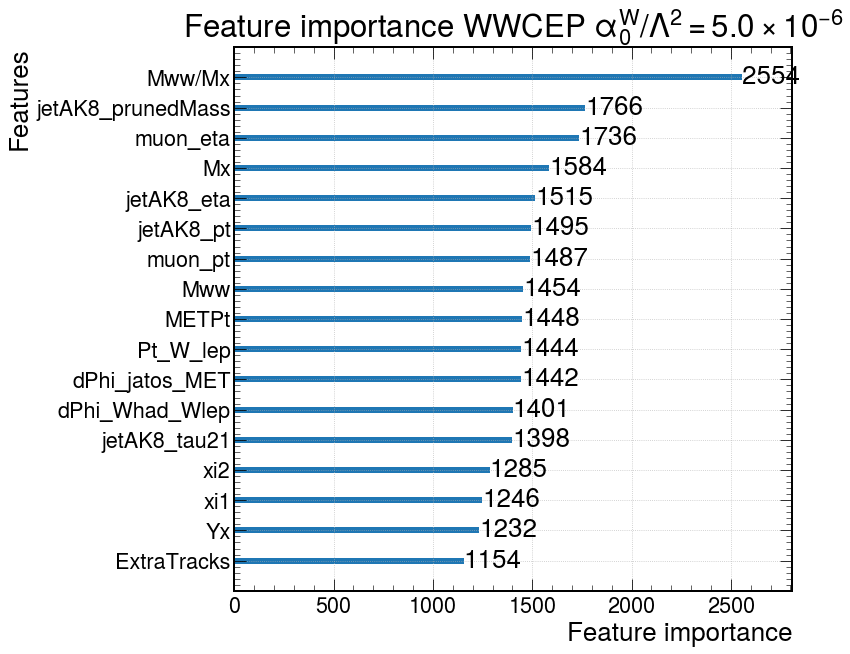

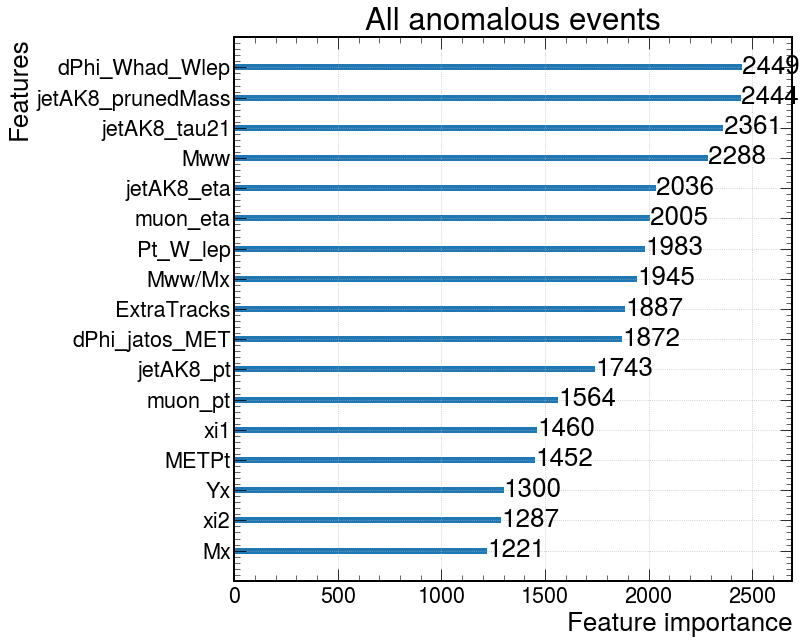

In [34]:
lgb.plot_importance(bst8_binary_logloss_scale_pos_weight, title = r'Feature importance WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )
#lgb.plot_importance(bst8_auc_scale_pos_weight, title = r'Feature importance WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )
#lgb.plot_importance(bst8_binary_logloss_is_unbalance, title = r'Feature importance WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )
#lgb.plot_importance(bst8_auc_is_unbalance, title = r'Feature importance WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )
#lgb.plot_importance(bst8_auc, title = r'Feature importance WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )
#lgb.plot_importance(bst8_binary_logloss, title = r'Feature importance WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )


lgb.plot_importance(bst_total_binary_logloss_scale_pos_weight, title = 'All anomalous events' )
#lgb.plot_importance(bst_total_auc_scale_pos_weight, title = 'All anomalous events' )
#lgb.plot_importance(bst_total_binary_logloss_is_unbalance, title = 'All anomalous events' )
#lgb.plot_importance(bst_total_auc_is_unbalance, title = 'All anomalous events' )
#lgb.plot_importance(bst_total_mdl_total_binary_logloss, title = 'All anomalous events' )
#lgb.plot_importance(bst_total_mdl_total_auc, title = 'All anomalous events' )

# Plotando métricas registradas durante o treinamento... 

In [35]:
def metrics( label_test, predict, sample_weight):
    false_positive, true_positive, thresholds = roc_curve( label_test, predict, sample_weight = sample_weight )
    precision, recall, threshs = precision_recall_curve( label_test, predict, sample_weight = sample_weight )
    f1_score = 2 * ( precision * recall ) / ( precision + recall )
    threshs = np.concatenate( [ threshs, [1] ], axis = 0 )
    return false_positive, true_positive, thresholds, precision, recall, threshs

In [36]:
fpr_lgb8_binary_logloss_scale_pos_weight, tpr_lgb8_binary_logloss_scale_pos_weight, thresholds_lgb8_binary_logloss_scale_pos_weight, prec_lgb8_binary_logloss_scale_pos_weight, rec_lgb8_binary_logloss_scale_pos_weight, threshs_lgb8_binary_logloss_scale_pos_weight = metrics(y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size )
fpr_lgb7_binary_logloss_scale_pos_weight, tpr_lgb7_binary_logloss_scale_pos_weight, thresholds_lgb7_binary_logloss_scale_pos_weight, prec_lgb7_binary_logloss_scale_pos_weight, rec_lgb7_binary_logloss_scale_pos_weight, threshs_lgb7_binary_logloss_scale_pos_weight = metrics(y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size )
fpr_lgb1_binary_logloss_scale_pos_weight, tpr_lgb1_binary_logloss_scale_pos_weight, thresholds_lgb1_binary_logloss_scale_pos_weight, prec_lgb1_binary_logloss_scale_pos_weight, rec_lgb1_binary_logloss_scale_pos_weight, threshs_lgb1_binary_logloss_scale_pos_weight = metrics(y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size )
fpr_lgb2_binary_logloss_scale_pos_weight, tpr_lgb2_binary_logloss_scale_pos_weight, thresholds_lgb2_binary_logloss_scale_pos_weight, prec_lgb2_binary_logloss_scale_pos_weight, rec_lgb2_binary_logloss_scale_pos_weight, threshs_lgb2_binary_logloss_scale_pos_weight = metrics(y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test2_weight/test_size )

### No caso em que temos concatenados todos os eventos anomalos, foi aplicado o peso neles

In [37]:
fpr_lgb_total_binary_logloss_scale_pos_weight, tpr_lgb_total_binary_logloss_scale_pos_weight, thresholds_lgb_total_binary_logloss_scale_pos_weight, prec_lgb_total_binary_logloss_scale_pos_weight, rec_lgb_total_binary_logloss_scale_pos_weight, threshs_lgb_total_binary_logloss_scale_pos_weight = metrics( y_test_total, predict_proba_LGBM_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test_total_weight/test_size )

### Aplicando o resultado do treinamento de todos os anômalos em um anomalo específico 

In [38]:
fpr_lgb_anomalo8_total_binary_logloss_scale_pos_weight, tpr_lgb_anomalo8_total_binary_logloss_scale_pos_weight, thresholds_lgb_anomalo8_total_binary_logloss_scale_pos_weight,prec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo8_total_binary_logloss_scale_pos_weight = metrics( y_test8, predict_proba_LGBM_anomalo8_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size )
fpr_lgb_anomalo7_total_binary_logloss_scale_pos_weight, tpr_lgb_anomalo7_total_binary_logloss_scale_pos_weight, thresholds_lgb_anomalo7_total_binary_logloss_scale_pos_weight,prec_lgb_anomalo7_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo7_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo7_total_binary_logloss_scale_pos_weight = metrics( y_test7, predict_proba_LGBM_anomalo7_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size )
fpr_lgb_anomalo1_total_binary_logloss_scale_pos_weight, tpr_lgb_anomalo1_total_binary_logloss_scale_pos_weight, thresholds_lgb_anomalo1_total_binary_logloss_scale_pos_weight,prec_lgb_anomalo1_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo1_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo1_total_binary_logloss_scale_pos_weight = metrics( y_test1, predict_proba_LGBM_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size )
fpr_lgb_anomalo2_total_binary_logloss_scale_pos_weight, tpr_lgb_anomalo2_total_binary_logloss_scale_pos_weight, thresholds_lgb_anomalo2_total_binary_logloss_scale_pos_weight,prec_lgb_anomalo2_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo2_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo2_total_binary_logloss_scale_pos_weight = metrics( y_test2, predict_proba_LGBM_anomalo2_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test2_weight/test_size )

<ipython-input-35-547b4fa52803>:4: RuntimeWarning: invalid value encountered in true_divide
  f1_score = 2 * ( precision * recall ) / ( precision + recall )


# Determinando o melhor corte

In [39]:
def best_cut( precision, recall, threshs_lgb, label, predict ):
    bidx = np.argmax( precision * recall )
    best_cut = threshs_lgb[bidx]
    print('\n',' Best Cut Anomalo_{} ---> '.format(label), best_cut,'\n')
    predict_cut = predict >= best_cut
    return best_cut, predict_cut

In [40]:
best_cut8_binary_logloss_scale_pos_weight, y_pred_cut8_binary_logloss_scale_pos_weight = best_cut( prec_lgb8_binary_logloss_scale_pos_weight, rec_lgb8_binary_logloss_scale_pos_weight, threshs_lgb8_binary_logloss_scale_pos_weight, 8, predict_proba_LGBM8_binary_logloss_scale_pos_weight)


  Best Cut Anomalo_8 --->  0.52756736931751 



In [41]:
best_cut7_binary_logloss_scale_pos_weight, y_pred_cut7_binary_logloss_scale_pos_weight = best_cut( prec_lgb7_binary_logloss_scale_pos_weight, rec_lgb7_binary_logloss_scale_pos_weight, threshs_lgb7_binary_logloss_scale_pos_weight, 7, predict_proba_LGBM7_binary_logloss_scale_pos_weight)


  Best Cut Anomalo_7 --->  0.6581649845007809 



In [42]:
best_cut1_binary_logloss_scale_pos_weight, y_pred_cut1_binary_logloss_scale_pos_weight = best_cut( prec_lgb1_binary_logloss_scale_pos_weight, rec_lgb1_binary_logloss_scale_pos_weight, threshs_lgb1_binary_logloss_scale_pos_weight, 1, predict_proba_LGBM1_binary_logloss_scale_pos_weight)


  Best Cut Anomalo_1 --->  0.6663172227860609 



In [43]:
best_cut2_binary_logloss_scale_pos_weight, y_pred_cut2_binary_logloss_scale_pos_weight = best_cut( prec_lgb2_binary_logloss_scale_pos_weight, rec_lgb2_binary_logloss_scale_pos_weight, threshs_lgb2_binary_logloss_scale_pos_weight, 2, predict_proba_LGBM2_binary_logloss_scale_pos_weight)


  Best Cut Anomalo_2 --->  0.5108046295414356 



In [44]:
best_cut_total_binary_logloss_scale_pos_weight, y_pred_cut_total_binary_logloss_scale_pos_weight = best_cut( prec_lgb_total_binary_logloss_scale_pos_weight, rec_lgb_total_binary_logloss_scale_pos_weight, threshs_lgb_total_binary_logloss_scale_pos_weight, 'total', predict_proba_LGBM_total_binary_logloss_scale_pos_weight )


  Best Cut Anomalo_total --->  0.7230526922181343 



In [45]:
best_cut_anomalo8_total_binary_logloss_scale_pos_weight, y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight = best_cut( prec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo8_total_binary_logloss_scale_pos_weight, '8 com total', predict_proba_LGBM_anomalo8_total_binary_logloss_scale_pos_weight )


  Best Cut Anomalo_8 com total --->  0.8426620617027583 



In [46]:
best_cut_anomalo7_total_binary_logloss_scale_pos_weight, y_pred_cut_anomalo7_total_binary_logloss_scale_pos_weight = best_cut( prec_lgb_anomalo7_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo7_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo7_total_binary_logloss_scale_pos_weight, '7 com total', predict_proba_LGBM_anomalo7_total_binary_logloss_scale_pos_weight )


  Best Cut Anomalo_7 com total --->  0.9155268111301701 



In [47]:
best_cut_anomalo1_total_binary_logloss_scale_pos_weight, y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight = best_cut( prec_lgb_anomalo1_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo1_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo1_total_binary_logloss_scale_pos_weight, '1 com total', predict_proba_LGBM_anomalo1_total_binary_logloss_scale_pos_weight )


  Best Cut Anomalo_1 com total --->  0.723432400260098 



In [48]:
best_cut_anomalo2_total_binary_logloss_scale_pos_weight, y_pred_cut_anomalo2_total_binary_logloss_scale_pos_weight = best_cut( prec_lgb_anomalo2_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo2_total_binary_logloss_scale_pos_weight, threshs_lgb_anomalo2_total_binary_logloss_scale_pos_weight, '2 com total', predict_proba_LGBM_anomalo2_total_binary_logloss_scale_pos_weight )


  Best Cut Anomalo_2 com total --->  0.9909267585181718 



# Gráfico Precision x Recall

In [49]:
def plot_precision_recall( recall, precision, label_test, y_pred_cut, nome ):
    plt.subplots( figsize=(10,7) )
    plt.plot( recall, precision )
    plt.xlabel( ' Recall ' )
    plt.ylabel( ' Precision' )
    plt.text(0.1,0.4, nome, fontsize = 18 )
    plt.title( 'Average precision score = {0:0.3f} '.format( average_precision_score(label_test,y_pred_cut ) ) )

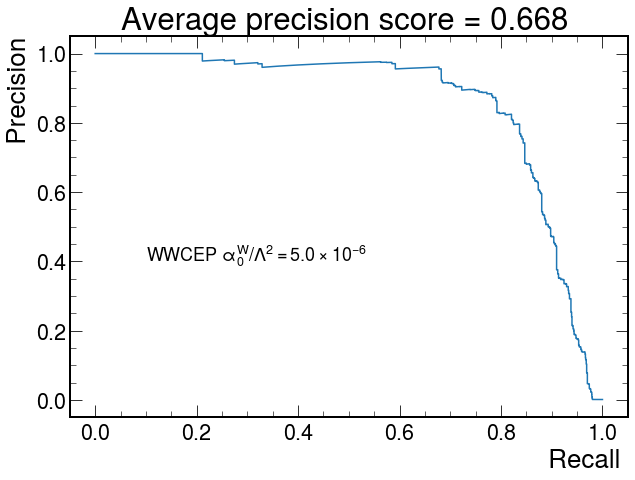

In [50]:
plot_precision_recall( rec_lgb8_binary_logloss_scale_pos_weight, prec_lgb8_binary_logloss_scale_pos_weight, y_test8, y_pred_cut8_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $')

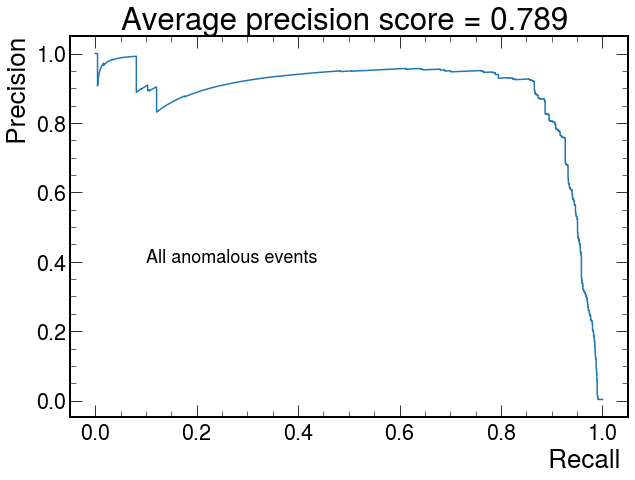

In [51]:
plot_precision_recall( rec_lgb_total_binary_logloss_scale_pos_weight, prec_lgb_total_binary_logloss_scale_pos_weight, y_test_total, y_pred_cut_total_binary_logloss_scale_pos_weight,'All anomalous events' )

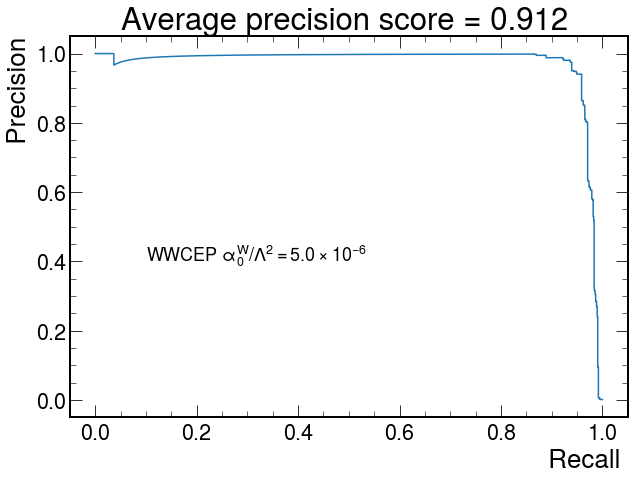

In [52]:
plot_precision_recall( rec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, prec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, y_test8, y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )

# Plot do melhor corte

In [53]:
def plot_best_cut( threshs, precision, recall, best_cut, title):
    plt.plot( threshs , precision * recall,  color = 'blue' )
    plt.plot( [ best_cut , best_cut ] , [-0.1,(precision * recall).max()*2] ,"-.r",label='Best Cut : {:2.5f}'.format(best_cut) )
    plt.plot( [-0.1,1.1] , [ (precision*recall).max(),(precision*recall).max()], ":g",label=r'Precision $\times$ Recall : {:2.5f}'.format((precision*recall).max()) )
    plt.ylabel( r'Precision $\times$ Recall' )
    plt.xlabel(    'Thresholds'    )
    plt.ylim( -0.1 , 1 )
    plt.xlim( -0.01 , 1 )
    plt.title( title )
    plt.legend( loc = "best", fontsize = 17)

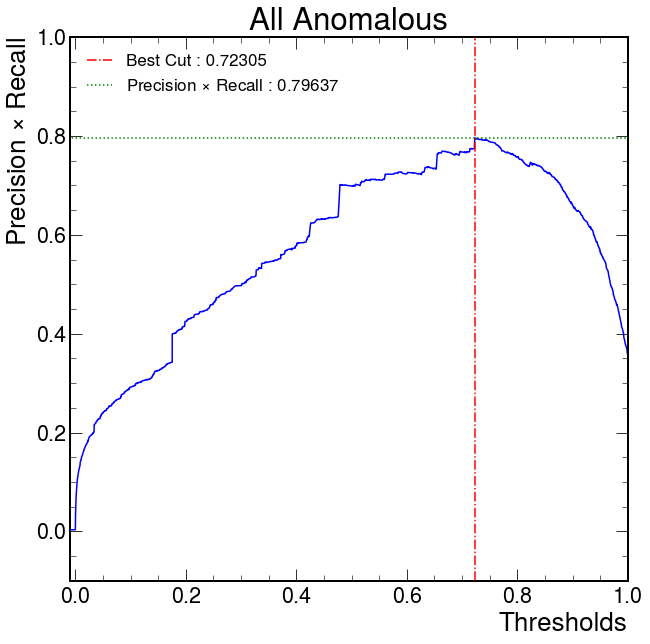

In [54]:
plot_best_cut( threshs_lgb_total_binary_logloss_scale_pos_weight, prec_lgb_total_binary_logloss_scale_pos_weight, rec_lgb_total_binary_logloss_scale_pos_weight, best_cut_total_binary_logloss_scale_pos_weight, 'All Anomalous')

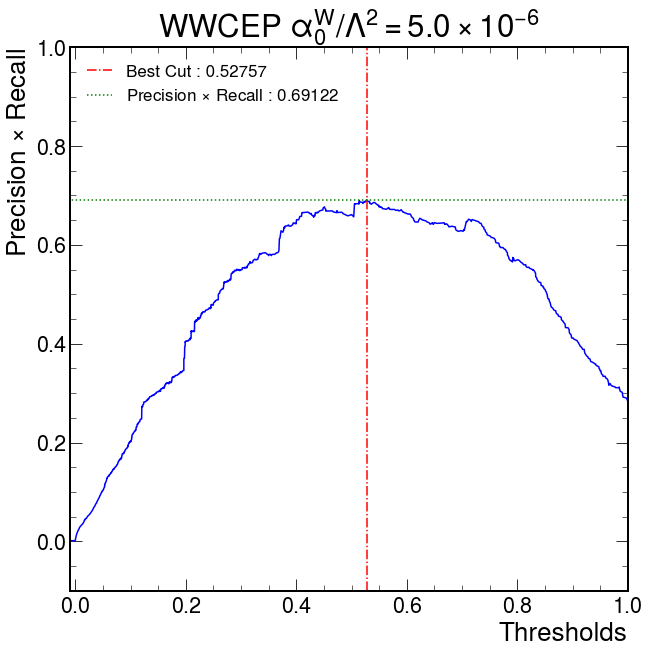

In [55]:
plot_best_cut( threshs_lgb8_binary_logloss_scale_pos_weight, prec_lgb8_binary_logloss_scale_pos_weight, rec_lgb8_binary_logloss_scale_pos_weight, best_cut8_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )

Aplicando o resultado do treinamento de todos os anomalos no signal anomalo 8 




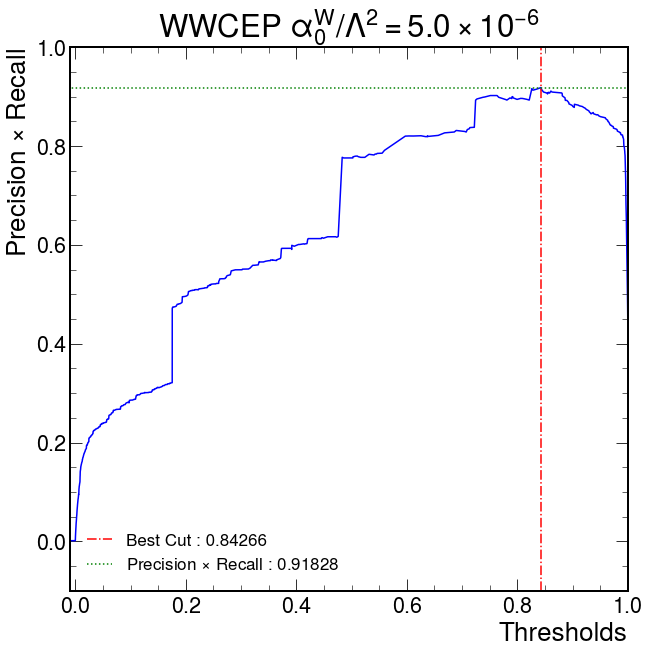

In [56]:
print('Aplicando o resultado do treinamento de todos os anomalos no signal anomalo 8 \n\n')

plot_best_cut( threshs_lgb_anomalo8_total_binary_logloss_scale_pos_weight, prec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, rec_lgb_anomalo8_total_binary_logloss_scale_pos_weight, best_cut_anomalo8_total_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )

# Plot do Discriminante

In [57]:
def plot_errobar( array , bins=25 ):
    counts_1, bin_edges_1 = np.histogram( array , bins = np.linspace(0,1,bins) )
    errors_1 = np.sqrt( counts_1 )
    bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
    plt.errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Dados-2016', color = 'black' )

Todos os Anômalos
[-8.70064974e-05 -1.34249110e-04  5.16437581e-05 ...  1.88647268e-05
  3.79776197e-04  4.85684613e-05]


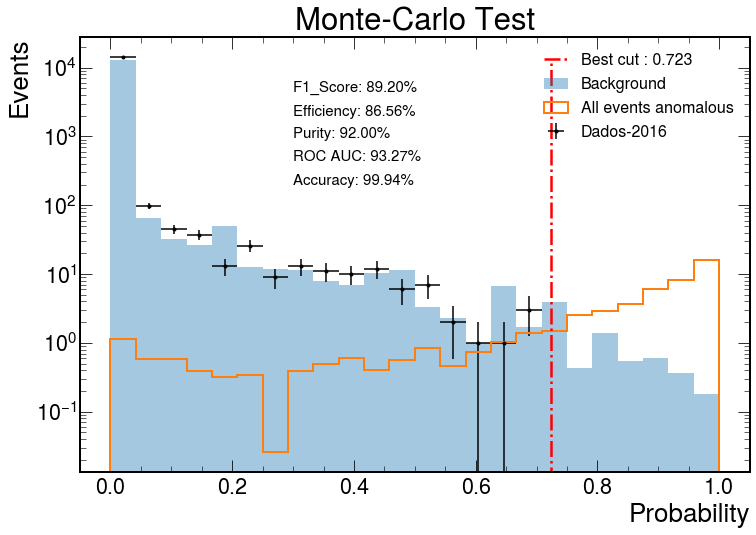

In [58]:
print('Todos os Anômalos')

predict_dados = bst_total_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (12,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM_total_binary_logloss_scale_pos_weight[ y_test_total == 0 ], alpha = 0.4, histtype = 'bar', bins = np.linspace(0,1,25), label = 'Background', weights = DataSet_Test_total_weight_backgr/test_size )
hsigt_lgb = plt.hist(predict_proba_LGBM_total_binary_logloss_scale_pos_weight[ y_test_total == 1 ], ls='-', linewidth=2., bins = np.linspace(0,1,25), histtype = 'step', label = r'All events anomalous', weights = DataSet_Test_total_weight_signal/test_size )

plot_errobar(predict_dados[predict_dados < best_cut_total_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut_total_binary_logloss_scale_pos_weight,best_cut_total_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5, label='Best cut : {:2.3f}'.format( best_cut_total_binary_logloss_scale_pos_weight ) )

plt.text(0.3,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test_total,y_pred_cut_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test_total_weight/test_size )), fontsize = 15 )
plt.text(0.3,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test_total,y_pred_cut_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test_total_weight/test_size)), fontsize = 15 )
plt.text(0.3,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test_total,y_pred_cut_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test_total_weight/test_size)), fontsize = 15 )
plt.text(0.3,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test_total,y_pred_cut_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test_total_weight/test_size)), fontsize = 15 )
plt.text(0.3,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test_total,y_pred_cut_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test_total_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper right", fontsize = 16 )
plt.yscale( 'log' )

Signal Anomalo 8
[ 0.00016801 -0.00529532  0.00058205 ...  0.00010891  0.00114836
  0.00281168]


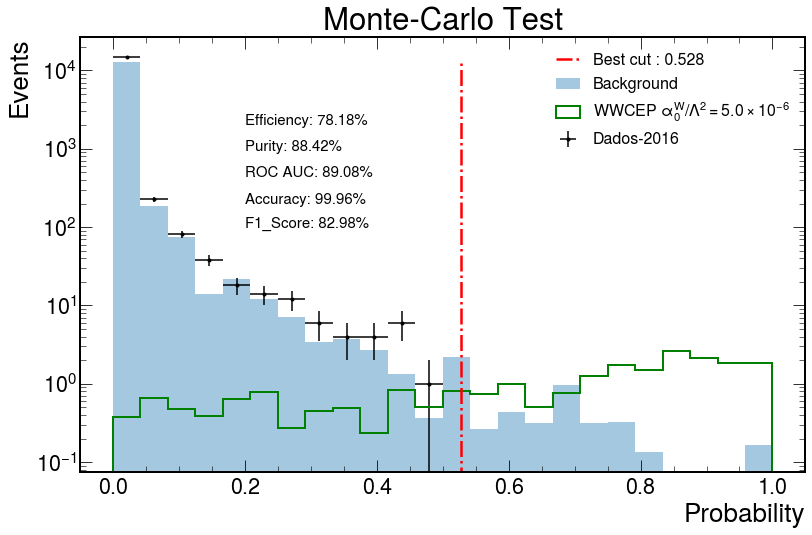

In [59]:
print('Signal Anomalo 8')

predict_dados = bst8_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (13,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 0 ], bins = np.linspace(0,1,25), alpha = 0.4, histtype = 'bar', label = 'Background', weights = DataSet_Test8_weight_backgr/test_size )
hsigt_lgb = plt.hist(predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 1 ], bins = np.linspace(0,1,25), ls='-', linewidth=2., histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', weights = DataSet_Test8_weight_signal/test_size, color = 'green' )

plot_errobar(predict_dados[predict_dados < best_cut8_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut8_binary_logloss_scale_pos_weight,best_cut8_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut8_binary_logloss_scale_pos_weight ) )

plt.text(0.2,9.5e2,"Purity: {:2.2f}%".format( 100*precision_score(y_test8,y_pred_cut8_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size )), fontsize = 15 )
plt.text(0.2,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test8,y_pred_cut8_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )
plt.text(0.2,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test8,y_pred_cut8_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )
plt.text(0.2,10e1, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test8,y_pred_cut8_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )
plt.text(0.2,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test8,y_pred_cut8_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper right", fontsize = 16 )
plt.yscale( 'log' )

Signal Anomalo 7
[ 3.58975554e-04 -1.18772129e-04 -1.59430482e-05 ... -5.38955940e-05
 -1.32599993e-03 -3.23806387e-05]


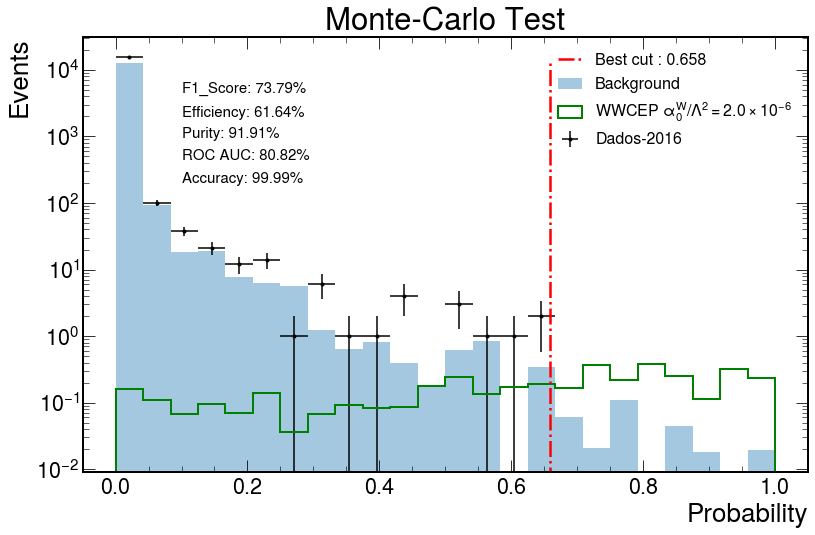

In [60]:
print('Signal Anomalo 7')

predict_dados = bst7_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (13,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 0 ], bins = np.linspace(0,1,25), alpha = 0.4, histtype = 'bar', label = 'Background', weights = DataSet_Test7_weight_backgr/test_size )
hsigt_lgb = plt.hist(predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 1 ], bins = np.linspace(0,1,25), ls='-', linewidth=2., histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', weights = DataSet_Test7_weight_signal/test_size, color = 'green' )

plot_errobar(predict_dados[predict_dados < best_cut7_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut7_binary_logloss_scale_pos_weight,best_cut7_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut7_binary_logloss_scale_pos_weight ) )

plt.text(0.1,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test7,y_pred_cut7_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size )), fontsize = 15 )
plt.text(0.1,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test7,y_pred_cut7_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )
plt.text(0.1,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test7,y_pred_cut7_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )
plt.text(0.1,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test7,y_pred_cut7_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )
plt.text(0.1,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test7,y_pred_cut7_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper right", fontsize = 16 )
plt.yscale( 'log' )

Signal Anomalo 1
[ 3.40691570e-03 -8.16048017e-04  7.56488204e-05 ...  9.40579817e-05
 -1.29151825e-04 -1.14804527e-05]


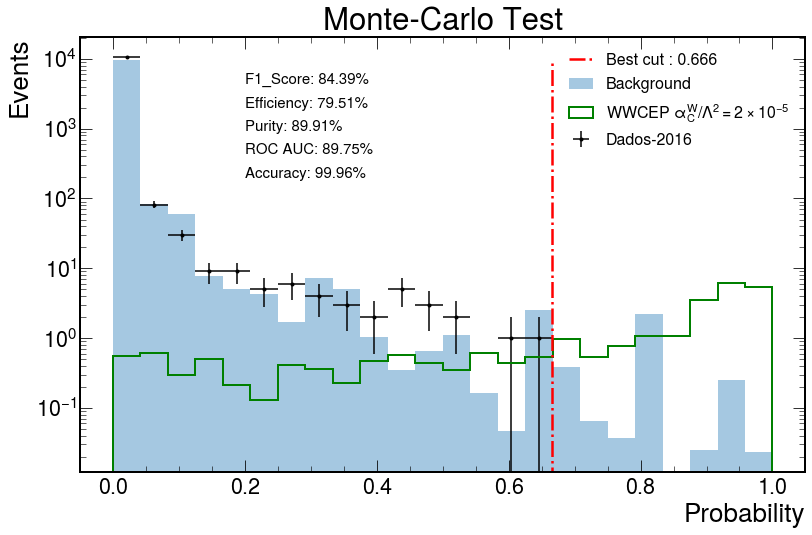

In [61]:
print('Signal Anomalo 1')

predict_dados = bst1_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (13,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 0 ], bins = np.linspace(0,1,25), alpha = 0.4, histtype = 'bar', label = 'Background', weights = DataSet_Test1_weight_backgr/test_size )
hsigt_lgb = plt.hist(predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 1 ], bins = np.linspace(0,1,25), ls='-', linewidth=2., histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-5}$', weights = DataSet_Test1_weight_signal/test_size, color = 'green' )

plot_errobar(predict_dados[predict_dados < best_cut1_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut1_binary_logloss_scale_pos_weight,best_cut1_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut1_binary_logloss_scale_pos_weight ) )

plt.text(0.2,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test1,y_pred_cut1_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size )), fontsize = 15 )
plt.text(0.2,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test1,y_pred_cut1_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
plt.text(0.2,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test1,y_pred_cut1_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
plt.text(0.2,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test1,y_pred_cut1_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
plt.text(0.2,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test1,y_pred_cut1_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper right", fontsize = 16 )
plt.yscale( 'log' )

Signal Anomalo 2
[ 0.00353718 -0.00455234 -0.00085081 ... -0.00055464 -0.00842809
 -0.00011456]


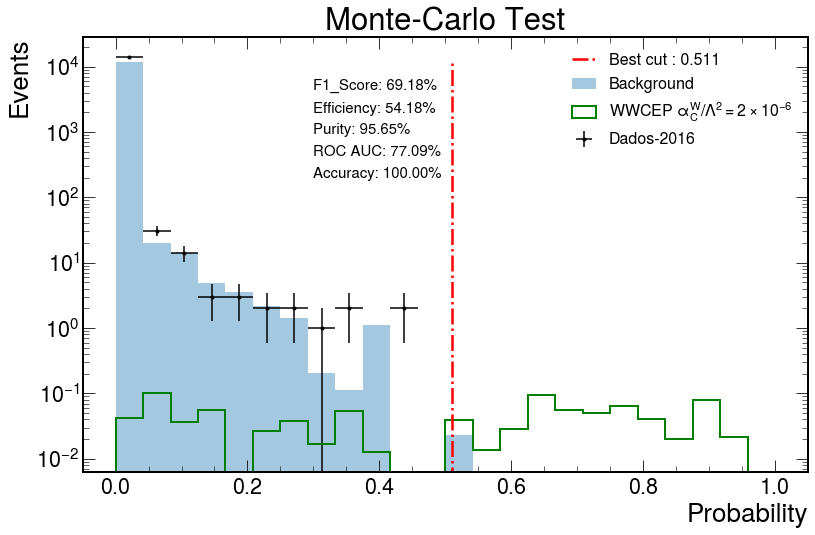

In [73]:
print('Signal Anomalo 2')

predict_dados = bst2_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (13,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 0 ], bins = np.linspace(0,1,25), alpha = 0.4, histtype = 'bar', label = 'Background', weights = DataSet_Test2_weight_backgr/test_size )
hsigt_lgb = plt.hist(predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 1 ], bins = np.linspace(0,1,25), ls='-', linewidth=2., histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-6}$', weights = DataSet_Test2_weight_signal/test_size, color = 'green' )

plot_errobar(predict_dados[predict_dados < best_cut2_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut2_binary_logloss_scale_pos_weight,best_cut2_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut2_binary_logloss_scale_pos_weight ) )

plt.text(0.3,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test2,y_pred_cut2_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test2_weight/test_size )), fontsize = 15 )
plt.text(0.3,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test2,y_pred_cut2_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test2_weight/test_size)), fontsize = 15 )
plt.text(0.3,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test2,y_pred_cut2_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test2_weight/test_size)), fontsize = 15 )
plt.text(0.3,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test2,y_pred_cut2_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test2_weight/test_size)), fontsize = 15 )
plt.text(0.3,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test2,y_pred_cut2_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test2_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper right", fontsize = 16 )
plt.yscale( 'log' )

Todos os anomalos aplicado no anomalo 8
[-8.70064974e-05 -1.34249110e-04  5.16437581e-05 ...  1.88647268e-05
  3.79776197e-04  4.85684613e-05]


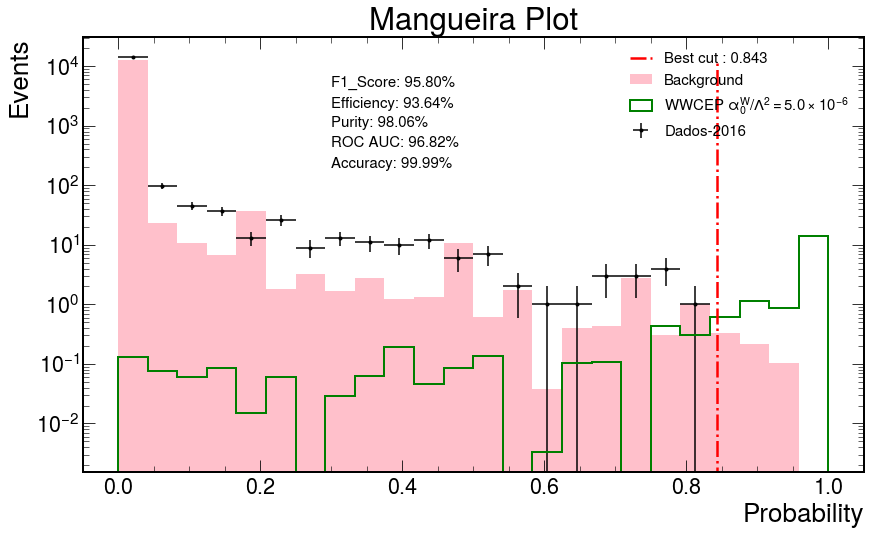

In [63]:
print('Todos os anomalos aplicado no anomalo 8')

predict_dados = bst_total_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (14,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM_anomalo8_total_binary_logloss_scale_pos_weight[ y_test8 == 0 ], alpha = 0.99, histtype = 'bar', bins = np.linspace(0,1,25),  label = 'Background', weights = DataSet_Test8_weight_backgr/test_size, color = 'pink' )
hsigt_lgb = plt.hist(predict_proba_LGBM_anomalo8_total_binary_logloss_scale_pos_weight[ y_test8 == 1 ], ls='-', linewidth=2., bins = np.linspace(0,1,25), histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', color = 'green', weights = DataSet_Test8_weight_signal/test_size )

plot_errobar(predict_dados[predict_dados < best_cut_anomalo8_total_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut_anomalo8_total_binary_logloss_scale_pos_weight,best_cut_anomalo8_total_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5, label='Best cut : {:2.3f}'.format( best_cut_anomalo8_total_binary_logloss_scale_pos_weight ) )

plt.text(0.3,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test8,y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size )), fontsize = 15 )
plt.text(0.3,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test8,y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )
plt.text(0.3,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test8,y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )
plt.text(0.3,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test8,y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )
plt.text(0.3,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test8,y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test8_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Mangueira Plot" )
plt.legend( loc = "upper right", fontsize = 15 )
plt.yscale( 'log' )

Todos os anomalos aplicado no anomalo 7
[-8.70064974e-05 -1.34249110e-04  5.16437581e-05 ...  1.88647268e-05
  3.79776197e-04  4.85684613e-05]


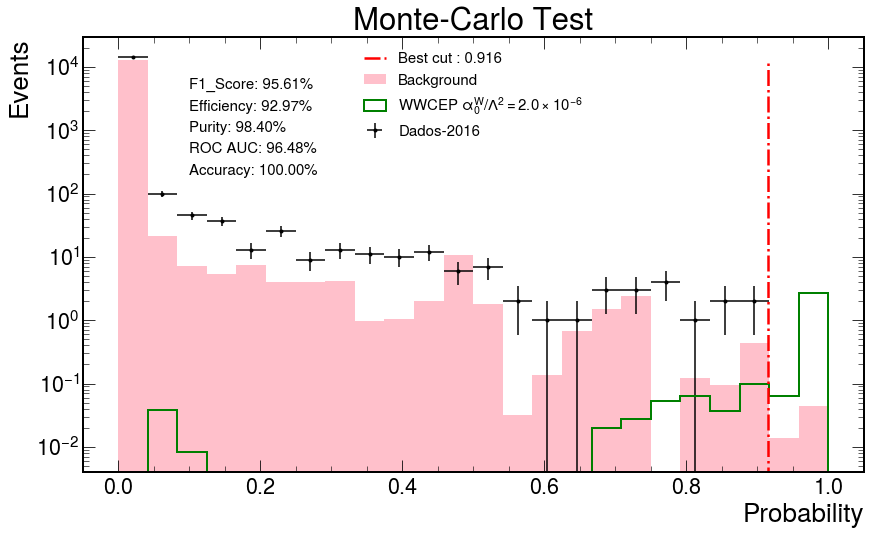

In [64]:
print('Todos os anomalos aplicado no anomalo 7')

predict_dados = bst_total_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (14,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM_anomalo7_total_binary_logloss_scale_pos_weight[ y_test7 == 0 ], alpha = 0.99, histtype = 'bar', bins = np.linspace(0,1,25),  label = 'Background', weights = DataSet_Test7_weight_backgr/test_size, color = 'pink' )
hsigt_lgb = plt.hist(predict_proba_LGBM_anomalo7_total_binary_logloss_scale_pos_weight[ y_test7 == 1 ], ls='-', linewidth=2., bins = np.linspace(0,1,25), histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', color = 'green', weights = DataSet_Test7_weight_signal/test_size )

plot_errobar(predict_dados[predict_dados < best_cut_anomalo7_total_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut_anomalo7_total_binary_logloss_scale_pos_weight,best_cut_anomalo7_total_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5, label='Best cut : {:2.3f}'.format( best_cut_anomalo7_total_binary_logloss_scale_pos_weight ) )

plt.text(0.1,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test7,y_pred_cut_anomalo7_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size )), fontsize = 15 )
plt.text(0.1,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test7,y_pred_cut_anomalo7_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )
plt.text(0.1,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test7,y_pred_cut_anomalo7_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )
plt.text(0.1,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test7,y_pred_cut_anomalo7_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )
plt.text(0.1,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test7,y_pred_cut_anomalo7_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test7_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper center", fontsize = 15 )
plt.yscale( 'log' )

Todos os anomalos aplicado no anomalo 1
[-8.70064974e-05 -1.34249110e-04  5.16437581e-05 ...  1.88647268e-05
  3.79776197e-04  4.85684613e-05]


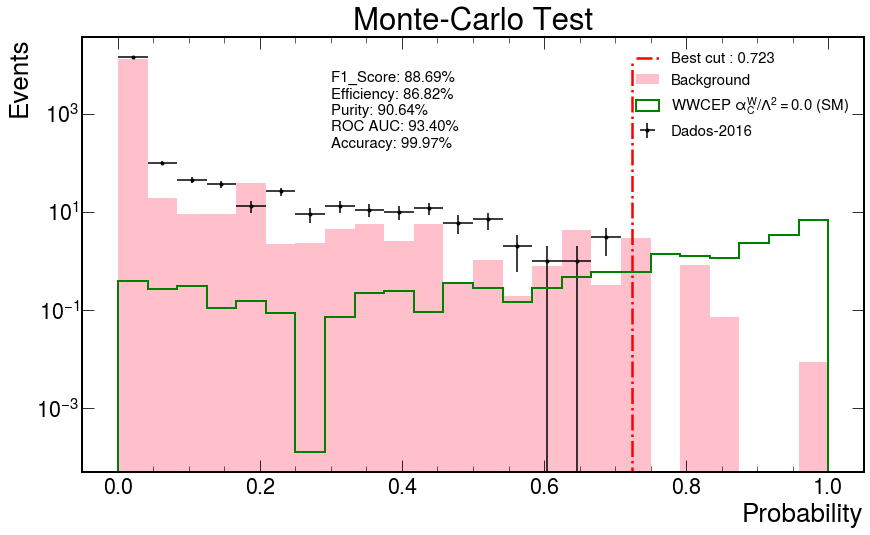

In [65]:
print('Todos os anomalos aplicado no anomalo 1')

predict_dados = bst_total_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (14,8))

hbgt_lgb =  plt.hist(predict_proba_LGBM_anomalo1_total_binary_logloss_scale_pos_weight[ y_test1 == 0 ], alpha = 0.99, histtype = 'bar', bins = np.linspace(0,1,25),  label = 'Background', weights = DataSet_Test1_weight_backgr/test_size, color = 'pink' )
hsigt_lgb = plt.hist(predict_proba_LGBM_anomalo1_total_binary_logloss_scale_pos_weight[ y_test1 == 1 ], ls='-', linewidth=2., bins = np.linspace(0,1,25), histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=0.0$ (SM)', color = 'green', weights = DataSet_Test1_weight_signal/test_size )

plot_errobar(predict_dados[predict_dados < best_cut_anomalo1_total_binary_logloss_scale_pos_weight])

uppery_lgb=np.max(hbgt_lgb[0])
plt.plot([best_cut_anomalo1_total_binary_logloss_scale_pos_weight,best_cut_anomalo1_total_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5, label='Best cut : {:2.3f}'.format( best_cut_anomalo1_total_binary_logloss_scale_pos_weight ) )

plt.text(0.3,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size )), fontsize = 15 )
plt.text(0.3,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
plt.text(0.3,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
plt.text(0.3,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
plt.text(0.3,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper right", fontsize = 15 )
plt.yscale( 'log' )

Todos os anomalos aplicado no anomalo 1, 2, 7 e 8 
[-8.70064974e-05 -1.34249110e-04  5.16437581e-05 ...  1.88647268e-05
  3.79776197e-04  4.85684613e-05]


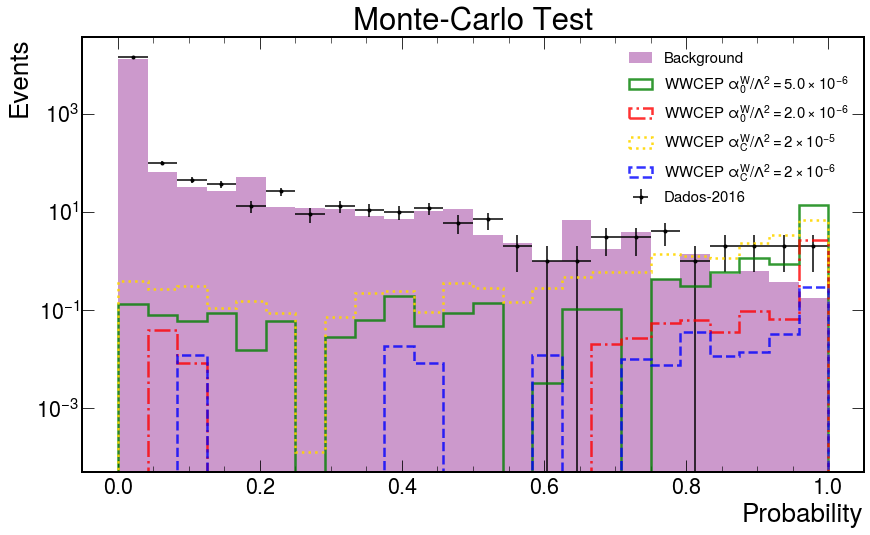

In [66]:
print('Todos os anomalos aplicado no anomalo 1, 2, 7 e 8 ')

predict_dados = bst_total_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp)
print(predict_dados)

plt.figure(figsize = (14,8))

hbgt_lgb = plt.hist(predict_proba_LGBM_total_binary_logloss_scale_pos_weight[ y_test_total == 0 ], color = 'purple', alpha = 0.4, histtype = 'bar', bins = np.linspace(0,1,25), label = 'Background', weights = DataSet_Test_total_weight_backgr/test_size )

plt.hist(predict_proba_LGBM_anomalo8_total_binary_logloss_scale_pos_weight[ y_test8 == 1 ], ls='-', linewidth=2.5,alpha = 0.8,  bins = np.linspace(0,1,25), histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', color = 'green', weights = DataSet_Test8_weight_signal/test_size )
plt.hist(predict_proba_LGBM_anomalo7_total_binary_logloss_scale_pos_weight[ y_test7 == 1 ], ls='-.', linewidth=2.5, alpha = 0.8, bins = np.linspace(0,1,25), histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', color = 'red', weights = DataSet_Test7_weight_signal/test_size )
plt.hist(predict_proba_LGBM_anomalo1_total_binary_logloss_scale_pos_weight[ y_test1 == 1 ], ls=':', linewidth=2.5, alpha = 0.9, bins = np.linspace(0,1,25), histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-5}$', color = 'gold', weights = DataSet_Test1_weight_signal/test_size )
plt.hist(predict_proba_LGBM_anomalo2_total_binary_logloss_scale_pos_weight[ y_test2 == 1 ], ls='--', linewidth=2.5, alpha = 0.8, bins = np.linspace(0,1,25), histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2 \times 10^{-6}$', color = 'blue', weights = DataSet_Test2_weight_signal/test_size )

plot_errobar(predict_dados)

#uppery_lgb=np.max(hbgt_lgb[0])
#plt.plot([best_cut_anomalo1_total_binary_logloss_scale_pos_weight,best_cut_anomalo1_total_binary_logloss_scale_pos_weight],[0,uppery_lgb],"-.r", linewidth=2.5, label='Best cut : {:2.3f}'.format( best_cut_anomalo1_total_binary_logloss_scale_pos_weight ) )

#plt.text(0.1,9.5e2, "Purity: {:2.2f}%".format( 100*precision_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size )), fontsize = 15 )
#plt.text(0.1,20e2, "Efficiency: {:2.2f}%".format( 100*recall_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
#plt.text(0.1,44e1, "ROC AUC: {:2.2f}%".format( 100*roc_auc_score(y_tes17,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
#plt.text(0.1,45e2, "F1_Score: {:2.2f}%".format( 100*f1_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )
#plt.text(0.1,20e1, "Accuracy: {:2.2f}%".format( 100*accuracy_score(y_test1,y_pred_cut_anomalo1_total_binary_logloss_scale_pos_weight, sample_weight = DataSet_Test1_weight/test_size)), fontsize = 15 )

plt.xlabel( "Probability" )
plt.ylabel( "Events" )
plt.title( "Monte-Carlo Test" )
plt.legend( loc = "upper right", fontsize = 15 )
plt.yscale( 'log' )

# Matriz de Confusão

In [67]:
def ConfusionMatrix( class_true, class_predict, cmap, title, sample_weight, fmt ):
    plt.subplots( figsize=(10,7) )
    conf_mat = confusion_matrix( y_true = class_true, y_pred = class_predict, sample_weight = sample_weight)
    print('Confusion matrix:\n', conf_mat)
    print('\n True Positives(TP)  --> ', conf_mat[0,0])
    print('\n True Negatives(TN)  --> ', conf_mat[1,1])
    print('\n False Positives(FP) --> ', conf_mat[0,1])
    print('\n False Negatives(FN) --> ', conf_mat[1,0])
    conf_mat = pd.DataFrame(conf_mat)
    conf_mat = conf_mat.rename(columns={0:'Background', 1:'Signal'})
    conf_mat = conf_mat.T
    conf_mat = conf_mat.rename(columns={0:'Background', 1:'Signal'})
    conf_mat = conf_mat.T
    sns.heatmap(conf_mat, annot=True, fmt=fmt, cmap = cmap) # fmt = d ou f
    plt.title(title)
    plt.xlabel('Predicted', fontsize = 30 )
    plt.ylabel('Expected' , fontsize = 30 )
    plt.tight_layout()
    plt.show()
    plt.close()

Confusion matrix:
 [[2.74979946e+04 3.41374282e+00]
 [7.27270869e+00 2.60556791e+01]]

 True Positives(TP)  -->  27497.994635651135

 True Negatives(TN)  -->  26.055679115360267

 False Positives(FP) -->  3.4137428196504573

 False Negatives(FN) -->  7.272708691560658


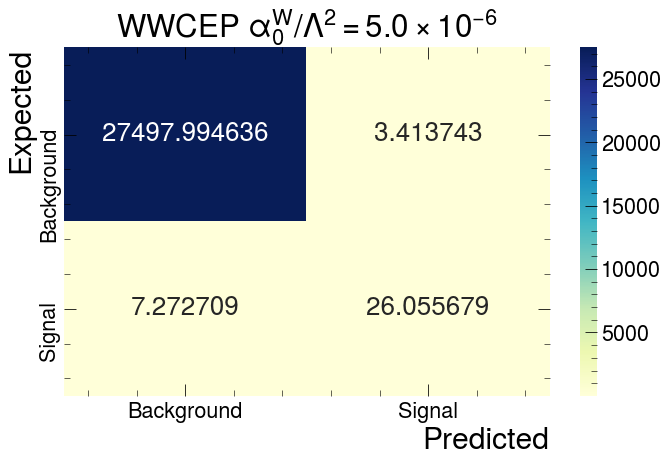

In [68]:
ConfusionMatrix(y_test8,y_pred_cut8_binary_logloss_scale_pos_weight,'YlGnBu',r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6}$', DataSet_Test8_weight/test_size, 'f')

Confusion matrix:
 [[2.73282764e+04 6.33767534e+00]
 [1.13126574e+01 7.28739975e+01]]

 True Positives(TP)  -->  27328.27639472973

 True Negatives(TN)  -->  72.87399746805731

 False Positives(FP) -->  6.337675341373467

 False Negatives(FN) -->  11.312657356232068


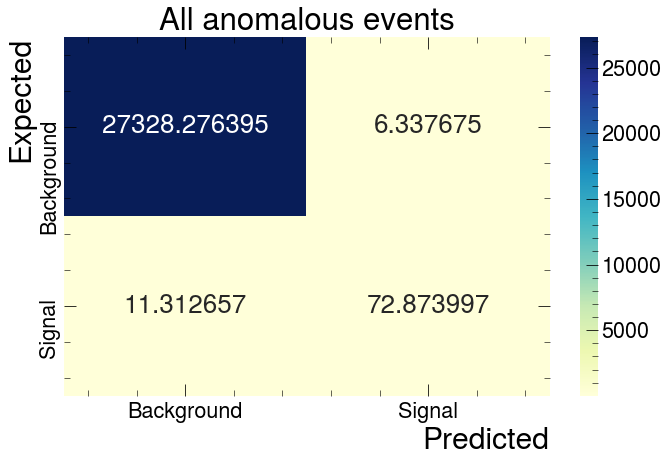

In [69]:
ConfusionMatrix( y_test_total, y_pred_cut_total_binary_logloss_scale_pos_weight, 'YlGnBu','All anomalous events', DataSet_Test_total_weight/test_size, 'f' )

Confusion matrix:
 [[2.75007919e+04 6.16429927e-01]
 [2.11898162e+00 3.12094062e+01]]

 True Positives(TP)  -->  27500.791948543967

 True Negatives(TN)  -->  31.209406186628062

 False Positives(FP) -->  0.61642992682431

 False Negatives(FN) -->  2.118981620292846


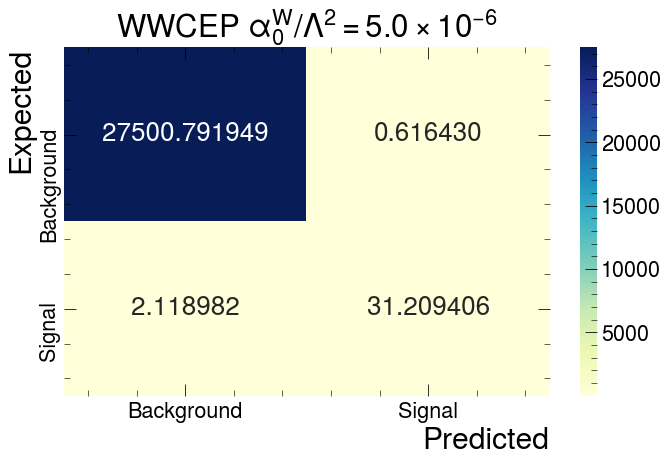

In [70]:
ConfusionMatrix( y_test8, y_pred_cut_anomalo8_total_binary_logloss_scale_pos_weight, 'YlGnBu',r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6}$', DataSet_Test8_weight/test_size, 'f' )

In [71]:
def plotROC(predictions,class_true,title):
    # choose score cuts:
    cuts = np.linspace(0,1,500); # Dividi o intervalo de 0 té 1 em 500 partes iguais 
    n_truePos = np.zeros(len(cuts)); # Cria uma matriz de zeros com o mesmo comprimento que o cuts, ou seja, 500
    n_falsePos = np.zeros(len(cuts));
    n_TotPos = len(np.where(class_true==1)[0]) # A partir da condição class_predict==1, retorna os valores em um array com essas condições. Com a função len(), retorna o comprimento desse array
    for i,cut in enumerate(cuts): # Enumerates organiza o array para melhor vizualizar
        y_pred = np.array([i>cut for i in predictions ])
        n_truePos[i] = len(np.where(predictions[class_true==1] > cut)[0]);
        n_falsePos[i] = len(np.where(predictions[class_true==0] > cut)[0]);
        if i%50 ==0:
            ascore = accuracy_score(class_true,y_pred)
            pscore = precision_score(class_true,y_pred)
            rscore = recall_score(class_true,y_pred)
            print("corte em {:2.1f} --> eficiência  {:2.1f} % e  pureza {:2.1f} %".format(cut,n_truePos[i]/n_TotPos *100,n_truePos[i]/(n_truePos[i]+n_falsePos[i])*100))
            print("accuracy_score = {:2.4f}     precision_score = {:2.4f}     recall_score = {:2.4f}\n".format(ascore,pscore,rscore))
    # plot efficiency vs. purity (ROC curve)
    plt.figure(figsize = (10,8));
    custom_cmap3 = ListedColormap(['orange','yellow','lightgreen',"lightblue","violet"])
    plt.scatter((n_truePos/n_TotPos),n_truePos/(n_truePos + n_falsePos),c=cuts,cmap=custom_cmap3,label="ROC");
    # make the plot readable
    plt.title(title)
    plt.xlabel('Efficiency');
    plt.ylabel('Purity');
    plt.colorbar()

In [72]:
data_set_back_multirp = pd.concat([data_set_back_multirp,data_set_back_multirp[]])
msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

SyntaxError: invalid syntax (<ipython-input-72-3192bdf224c0>, line 1)